<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_Iron(2_Edition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process**

# **(Percentage of Iron Concentrate) - 2.Edition**

## **1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

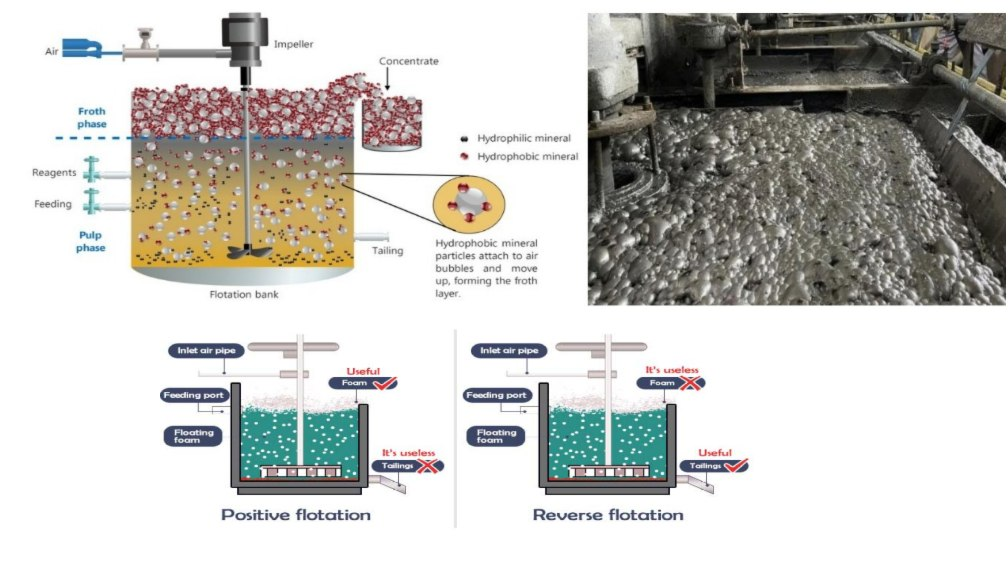

Flotation concentrate is periodically sampled to determine its purity (percentage of gangue). Higher purity in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict iron and gangue (silica) concentrate in the flotation output. The prediction will help process engineers assess the purity and take corrective actions in advance.

Source of dataset: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time. (There is imbalance in measurement of variables)
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

### **2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017).
- Measurements are taken every 5-6 hours for the first 2 columns (input - raw material).
- Measurements are taken every 1 hour for the last 2 columns (output - processed material).
- Some columns were sampled every 20 second.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant.
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process.
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality).
- The last two columns are the final iron ore pulp quality measurement from the lab.

### **2.3. Aim of the Project**

- To predict the percentage of output (**iron concentrate**) in the mineral processing (reverse cationic flotation) plant

##**3. Data Collection**

###**3.1. Import Libraries**

In [ ]:
import math
import random
import time
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, pearsonr
from scipy.cluster import hierarchy as hc
sns.set_theme(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

###**3.2. Import Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv',
                        parse_dates = True,decimal=',')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


**Memory using reduction**

In [ ]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


##**4. Data Preprocessing**

###**4.1. Dataset Information**

In [ ]:
flotation.sample(5).T

381575               730298  \
date                          2017-06-19 14:00:00  2017-09-08 08:00:00   
% Iron Feed                             44.900002            59.389999   
% Silica Feed                           30.120001                 7.74   
Starch Flow                           3326.169922          3598.610107   
Amina Flow                             549.971008           507.477997   
Ore Pulp Flow                          398.154999            417.76416   
Ore Pulp pH                               9.38972              9.34749   
Ore Pulp Density                          1.66643              1.68818   
Flotation Column 01 Air Flow           299.601013           299.268005   
Flotation Column 02 Air Flow           299.178986           300.053986   
Flotation Column 03 Air Flow           301.156006            297.51001   
Flotation Column 04 Air Flow           301.187988           300.962006   
Flotation Column 05 Air Flow           304.654999           297.752991   
Flotation Column 06 Air Flow           299.096008           294.618988   
Flotation Column 07 Air Flow           301.774994           293.701996   
Flotation Column 01 Level              391.195007           375.901001   
Flotation Column 02 Level              384.093994           237.272903   
Flotation Column 03 Level              405.183014           399.207001   
Flotation Column 04 Level               467.56601           385.602997   
Flotation Column 05 Level              456.703003           431.100006   
Flotation Column 06 Level              357.886993           410.333008   
Flotation Column 07 Level              432.535004           382.651001   
% Iron Concentrate                      64.129997            65.150002   
% Silica Concentrate                         3.63                 1.79   

                                           274439               448975  \
date                          2017-05-25 19:00:00  2017-07-05 05:00:00   
% Iron Feed                             64.029999            54.099998   
% Silica Feed                                6.26                15.33   
Starch Flow                           1330.446167          2888.669922   
Amina Flow                             433.106995           512.869019   
Ore Pulp Flow                          402.126007           395.049988   
Ore Pulp pH                               9.89791              9.56196   
Ore Pulp Density                          1.67553              1.67168   
Flotation Column 01 Air Flow           302.256012            297.38501   
Flotation Column 02 Air Flow           248.257996           299.437012   
Flotation Column 03 Air Flow           299.096008           299.204987   
Flotation Column 04 Air Flow           302.925995           299.424988   
Flotation Column 05 Air Flow           299.390991           300.303986   
Flotation Column 06 Air Flow           299.601013           302.009003   
Flotation Column 07 Air Flow           303.451996           297.070007   
Flotation Column 01 Level              445.502014           403.259003   
Flotation Column 02 Level               441.28299           474.334991   
Flotation Column 03 Level              440.020996           767.613831   
Flotation Column 04 Level              330.496002           235.582016   
Flotation Column 05 Level              345.835999           673.864929   
Flotation Column 06 Level              354.755005           374.993988   
Flotation Column 07 Level              375.848999           416.105988   
% Iron Concentrate                      65.550003            65.110001   
% Silica Concentrate                         1.15                 1.91   

                                           513564  
date                          2017-07-20 04:00:00  
% Iron Feed                             45.599998  
% Silica Feed                               29.92  
Starch Flow                            986.203003  
Amina Flow                             613.614014  
Ore Pulp Flow                

In [ ]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float32
 2   % Silica Feed                 737453 non-null  float32
 3   Starch Flow                   737453 non-null  float32
 4   Amina Flow                    737453 non-null  float32
 5   Ore Pulp Flow                 737453 non-null  float32
 6   Ore Pulp pH                   737453 non-null  float32
 7   Ore Pulp Density              737453 non-null  float32
 8   Flotation Column 01 Air Flow  737453 non-null  float32
 9   Flotation Column 02 Air Flow  737453 non-null  float32
 10  Flotation Column 03 Air Flow  737453 non-null  float32
 11  Flotation Column 04 Air Flow  737453 non-null  float32
 12  Flotation Column 05 Air Flow  737453 non-nul

In [ ]:
flotation.describe().T

count         mean          std         min  \
% Iron Feed                   737453.0    56.294743     5.157743   42.740002   
% Silica Feed                 737453.0    14.651719     6.807439    1.310000   
Starch Flow                   737453.0  2869.140381  1215.203735    0.002026   
Amina Flow                    737453.0   488.144653    91.230537  241.669006   
Ore Pulp Flow                 737453.0   397.578400     9.699785  376.248993   
Ore Pulp pH                   737453.0     9.767639     0.387007    8.753340   
Ore Pulp Density              737453.0     1.680380     0.069249    1.519820   
Flotation Column 01 Air Flow  737453.0   280.151886    29.621286  175.509995   
Flotation Column 02 Air Flow  737453.0   277.159973    30.149357  175.156006   
Flotation Column 03 Air Flow  737453.0   281.082489    28.558270  176.468994   
Flotation Column 04 Air Flow  737453.0   299.447845     2.572536  292.195007   
Flotation Column 05 Air Flow  737453.0   299.917816     3.636578  286.295013   
Flotation Column 06 Air Flow  737453.0   292.071503    30.217804  189.927994   
Flotation Column 07 Air Flow  737453.0   290.754883    28.670105  185.962006   
Flotation Column 01 Level     737453.0   520.244812   131.014923  149.218002   
Flotation Column 02 Level     737453.0   522.649597   128.165054  210.751999   
Flotation Column 03 Level     737453.0   531.352661   150.842163  126.254997   
Flotation Column 04 Level     737453.0   420.320984    91.794434  162.201004   
Flotation Column 05 Level     737453.0   425.251648    84.535820  166.990997   
Flotation Column 06 Level     737453.0   429.941040    89.862228  155.841003   
Flotation Column 07 Level     737453.0   421.021271    84.891495  175.348999   
% Iron Concentrate            737453.0    65.050049     1.118645   62.049999   
% Silica Concentrate          737453.0     2.326763     1.125554    0.600000   

                                      25%          50%          75%  \
% Iron Feed                     52.669998    56.080002    59.720001   
% Silica Feed                    8.940000    13.850000    19.600000   
Starch Flow                   2076.320068  3018.429932  3727.729980   
Amina Flow                     431.795990   504.393005   553.257019   
Ore Pulp Flow                  394.264008   399.248993   402.967987   
Ore Pulp pH                      9.527360     9.798100    10.038000   
Ore Pulp Density                 1.647310     1.697600     1.728330   
Flotation Column 01 Air Flow   250.281006   299.343994   300.148987   
Flotation Column 02 Air Flow   250.457001   296.222992   300.690002   
Flotation Column 03 Air Flow   250.854996   298.696014   300.381989   
Flotation Column 04 Air Flow   298.262573   299.804993   300.638000   
Flotation Column 05 Air Flow   298.067993   299.887115   301.791138   
Flotation Column 06 Air Flow   262.540985   299.476990   303.061005   
Flotation Column 07 Air Flow   256.302002   299.010986   301.903992   
Flotation Column 01 Level      416.977997   491.877991   594.114014   
Flotation Column 02 Level      441.882996   495.955994   595.463989   
Flotation Column 03 Level      411.325012   494.317993   601.249023   
Flotation Column 04 Level      356.678986   411.973999   485.549011   
Flotation Column 05 Level      357.653015   408.773010   484.329010   
Flotation Column 06 Level      358.497009   424.664581   492.683990   
Flotation Column 07 Level      356.772003   411.065002   476.464996   
% Iron Concentrate              64.370003    65.209999    65.860001   
% Silica Concentrate             1.440000     2.000000     3.010000   

                                      max  
% Iron Feed                     65.779999  
% Silica Feed                   33.400002  
Starch Flow                   6300.229980  
Amina Flow                     739.538025  
Ore Pulp Flow                  418.640991  
Ore Pulp pH                     10.808100  
Ore Pulp Density                 1.853250  
Flotation Column 01 Air Flow   373.871002  
Flotation C

###**4.2. Adjust and rename too long column names:**

In [ ]:
flotation.columns

Index(['date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [ ]:
# Rename column names
old_columns = ['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate']

new_columns = ["feed_Fe","feed_Si", "starch_flow", "amina_flow",
               "pulp_flow", "pulp_pH", "pulp_density",
               "air1", "air2", "air3", "air4", "air5", "air6", "air7",
               "level1", "level2", "level3", "level4", "level5", "level6", "level7",
               "conc_Fe", "conc_Si"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['date', 'feed_Fe', 'feed_Si', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'air1', 'air2', 'air3', 'air4', 'air5',
       'air6', 'air7', 'level1', 'level2', 'level3', 'level4', 'level5',
       'level6', 'level7', 'conc_Fe', 'conc_Si'],
      dtype='object')

The dataframe contains data about:

- Quality measures of the iron ore pulp before feeding it into the process (**inputs**)
- Features that can effect the quality of the product (**process parameters**)
- Quality measures of the iron ore pulp as product of the process (**outputs**)

### **4.3. Plot the variables graphs in time:**

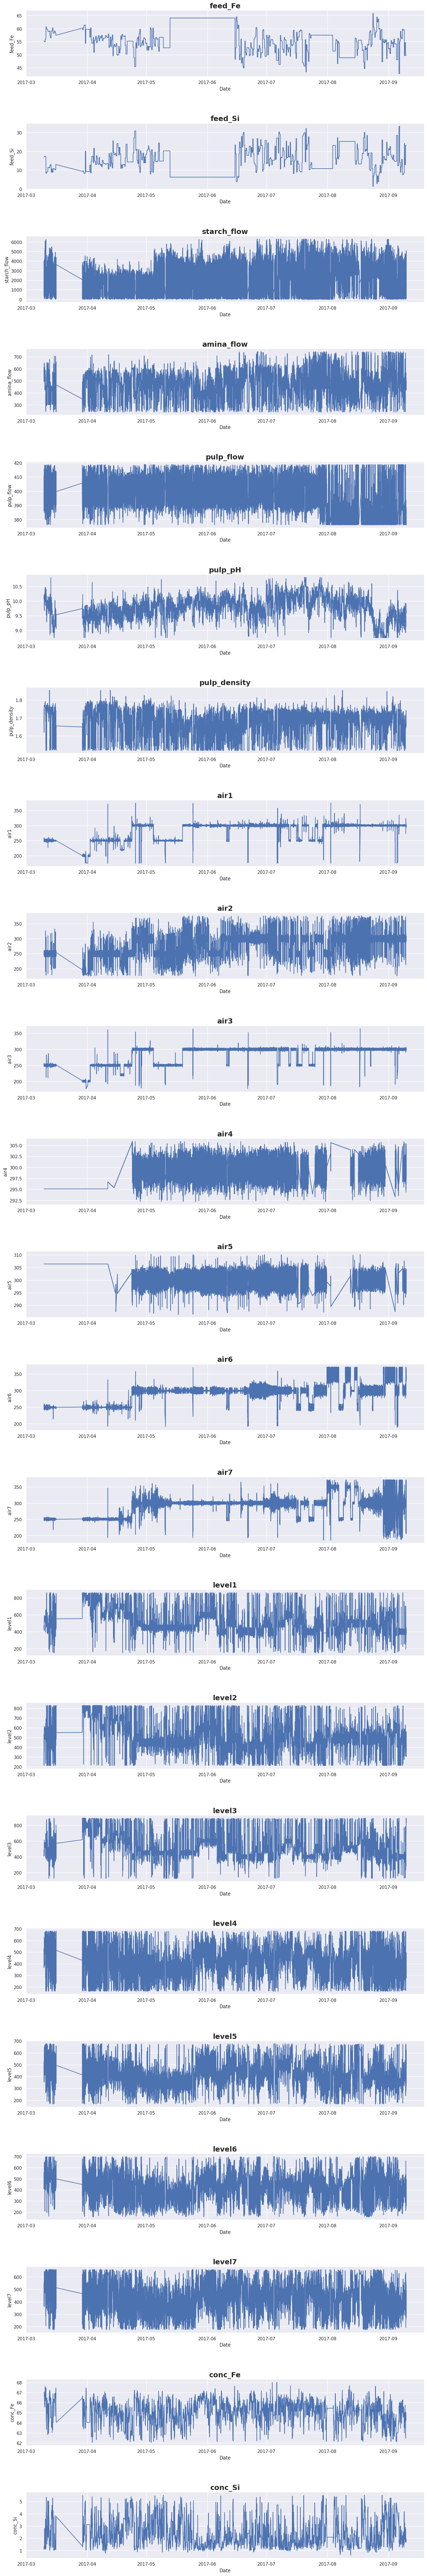

In [ ]:
# Convert 'date' column to datetime type
flotation['date'] = pd.to_datetime(flotation['date'])

# Set 'date' column as the index
flotation.set_index('date', inplace=True)

columns = flotation.columns

num_columns = 1
num_rows = (len(columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 90))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].plot(flotation.index, flotation[column])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].set_title(column, fontsize=18, fontweight='bold')

if len(columns) < len(axes):
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

plt.tight_layout(h_pad=5)
plt.show()

The dataset misses data packages of a couple of days. This was probably caused by a production shutdown. In order to rule out any influences from potentially corrupted data, it will be trimmed the data earlier of the restart of production ("2017-03-29 12:00:00"). We can also see that the quality of the products does not seem to follow a clear temporal dependency.

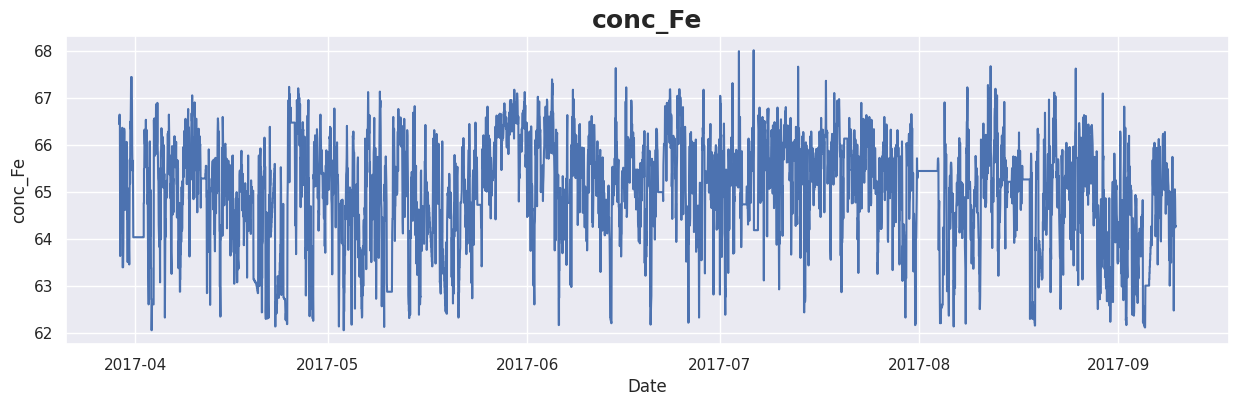

In [ ]:
sep_date = "2017-03-29 12:00:00"

# Trim the dataset by filtering rows after the specified sep_date
flotation = flotation[flotation.index >= sep_date]

plt.figure(figsize=(15, 4))
plt.plot(flotation.index, flotation['conc_Fe'])
plt.xlabel('Date')
plt.ylabel('conc_Fe')
plt.title('conc_Fe', fontsize=18, fontweight='bold')
plt.show()

In [ ]:
flotation.head().T

date          2017-03-29 12:00:00  2017-03-29 12:00:00  2017-03-29 12:00:00  \
feed_Fe                 60.180000            60.180000            60.180000   
feed_Si                  9.340000             9.340000             9.340000   
starch_flow           2044.989990          2020.550049          2012.839966   
amina_flow             349.911011           353.063995           356.217010   
pulp_flow              405.625000           404.402008           403.179993   
pulp_pH                  9.746040             9.741690             9.737330   
pulp_density             1.649650             1.643469             1.637289   
air1                   200.393005           200.130997           199.869003   
air2                   195.733994           196.475998           197.218994   
air3                   201.826004           200.908997           199.992004   
air4                   295.096008           295.096008           295.096008   
air5                   306.399994           306.399994           306.399994   
air6                   250.600998           250.207993           249.815002   
air7                   251.001999           250.828003           250.653000   
level1                 555.264465           557.839905           560.415405   
level2                 552.255554           554.531128           556.806702   
level3                 614.984741           659.557434           704.130127   
level4                 428.429993           431.145996           433.863007   
level5                 413.661987           422.308014           430.954010   
level6                 447.886993           444.325989           440.765015   
level7                 464.868988           463.223999           461.579010   
conc_Fe                 66.440002            66.440002            66.440002   
conc_Si                  1.360000             1.360000             1.360000   

date          2017-03-29 12:00:00  2017-03-29 12:00:00  
feed_Fe                 60.180000            60.180000  
feed_Si                  9.340000             9.340000  
starch_flow           2007.670044          2003.920044  
amina_flow             359.371002           362.523987  
pulp_flow              401.957001           400.734985  
pulp_pH                  9.732980             9.728620  
pulp_density             1.631108             1.624928  
air1                   199.606995           199.345001  
air2                   197.960999           198.703003  
air3                   199.074997           198.158005  
air4                   295.096008           295.096008  
air5                   306.399994           306.399994  
air6                   249.421997           249.029007  
air7                   250.477997           250.304001  
level1                 562.990845           565.566345  
level2                 559.082275           561.357849  
level3                 748.702881           793.275574  
level4                 436.579987           439.295990  
level5                 439.600006           448.246002  
level6                 437.204010           433.643005  
level7                 459.934998           458.290009  
conc_Fe                 66.440002            66.440002  
conc_Si                  1.360000             1.360000

In [ ]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 710639 entries, 2017-03-29 12:00:00 to 2017-09-09 23:00:00
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   feed_Fe       710639 non-null  float32
 1   feed_Si       710639 non-null  float32
 2   starch_flow   710639 non-null  float32
 3   amina_flow    710639 non-null  float32
 4   pulp_flow     710639 non-null  float32
 5   pulp_pH       710639 non-null  float32
 6   pulp_density  710639 non-null  float32
 7   air1          710639 non-null  float32
 8   air2          710639 non-null  float32
 9   air3          710639 non-null  float32
 10  air4          710639 non-null  float32
 11  air5          710639 non-null  float32
 12  air6          710639 non-null  float32
 13  air7          710639 non-null  float32
 14  level1        710639 non-null  float32
 15  level2        710639 non-null  float32
 16  level3        710639 non-null  float32
 17  level4        

### **4.5. Averaging dataset**

The dataset documentation reveals that different columns in the data are sampled at varying frequencies. Some features, like 'Ore Pulp Flow,' are recorded every 20 seconds, showcasing continuous changes throughout the process. On the other hand, features such as ('% Iron Feed' - '% Silica Feed') and ('% Iron Concentrate' - '% Silica Concentrate') are only logged once per hour. This discrepancy in sampling frequencies has important implications for how we interpret the data.

Treating each row as a separate observation might not accurately capture the true nature of the process, especially when including less frequently sampled features that remain constant over an hour. Simply using all the available samples for training a model fails to grasp the actual dynamics of the system.

One approach to address this issue involves aggregating the data by computing the average values of the 20-second samples within each hour. This process creates a new dataframe that represents the hourly average values, significantly reducing the data size by a factor of 180. By employing this approach, we obtain a more meaningful representation of the hourly trends. However, relying solely on mean values may result in the loss of crucial information present in the 20-second samples.

To mitigate the potential information loss from the 20-second samples, it is beneficial to consider the variations within each hour. Incorporating this variability can be accomplished by calculating additional statistics, such as the standard deviation of the meaned columns. Including these measures of variation allows us to capture the dynamics and fluctuations occurring within the hourly intervals, resulting in a more comprehensive representation of the process.

Considering the diverse sampling frequencies in the dataset and the trade-off between reducing data size and preserving information, aggregating the data to hourly means while incorporating measures of variability can offer a more meaningful depiction of the process dynamics. This aggregated representation can then be used for further analysis and modeling purposes.

In [ ]:
flotation_mean = flotation.copy()

# Convert the index to datetime
flotation_mean.index = pd.to_datetime(flotation_mean.index)
# Group the DataFrame by hourly intervals and calculate the mean
mean_grpby = flotation_mean.resample('1H').mean()
# Group the DataFrame by hourly intervals and calculate the standard deviation
std_grpby = flotation_mean.resample('1H').std()
# Remove columns with zero variance (null columns)
std_grpby = std_grpby.loc[:, (std_grpby != 0).any()]
# Add prefix 'std_' to the column names
std_grpby = std_grpby.add_prefix('std_')
# Merge the mean and standard deviation DataFrames on the index
flotation_merge = pd.concat([mean_grpby, std_grpby], axis=1)
# Assign the merged DataFrame back to 'flotation'
flotation = flotation_merge

Note: The purpose of removing columns with zero variance is to eliminate features that have constant values throughout the dataset. These columns do not contribute any useful information for modeling and can potentially cause issues during training. By removing them, we can reduce the dimensionality of the dataset and improve the model's performance.

In [ ]:
flotation.head().T

date              2017-03-29 12:00:00  2017-03-29 13:00:00  \
feed_Fe                     60.180000            60.180000   
feed_Si                      9.340000             9.340000   
starch_flow               1060.859253          2034.926514   
amina_flow                 379.836212           322.233978   
pulp_flow                  400.982544           400.468964   
pulp_pH                      9.527187             9.700680   
pulp_density                 1.550374             1.532017   
air1                       200.035858           199.990128   
air2                       195.577698           195.106247   
air3                       199.983719           199.765350   
air4                       295.096008           295.096008   
air5                       306.399994           306.399994   
air6                       250.069733           250.029053   
air7                       249.992950           250.059708   
level1                     753.724243           848.675537   
level2                     726.559448           777.784485   
level3                     860.557800           869.419434   
level4                     477.349213           483.816132   
level5                     452.512543           469.448181   
level6                     478.219666           471.607086   
level7                     470.105560           462.665497   
conc_Fe                     66.440002            66.570000   
conc_Si                      1.360000             1.430000   
std_starch_flow            878.197229           367.892914   
std_amina_flow              41.598406            65.562353   
std_pulp_flow                5.300055             2.921142   
std_pulp_pH                  0.096270             0.096915   
std_pulp_density             0.028278             0.019907   
std_air1                     0.323167             0.357018   
std_air2                     2.542617             2.617125   
std_air3                     1.304777             1.229616   
std_air4                     0.000000             0.000000   
std_air5                     0.000000             0.000000   
std_air6                     0.339138             0.347707   
std_air7                     0.950333             1.148208   
std_level1                  97.981104            12.356237   
std_level2                  85.517299            31.635046   
std_level3                  45.554947            39.871930   
std_level4                  90.034082            99.486562   
std_level5                 106.136343           128.562749   
std_level6                  65.240963            62.340593   
std_level7                  83.807140            69.998678   
std_conc_Fe                  0.000000             0.000000   
std_conc_Si                  0.000000             0.000000   

date              2017-03-29 14:00:00  2017-03-29 15:00:00  \
feed_Fe                     60.180000            60.180000   
feed_Si                      9.340000             9.340000   
starch_flow               1435.425781           618.460388   
amina_flow                 474.656342           396.377747   
pulp_flow                  399.157074           398.942535   
pulp_pH                      9.687788             9.851689   
pulp_density                 1.645200             1.559929   
air1                       200.019318           199.940842   
air2                       195.604919           195.657089   
air3                       199.925797           200.044342   
air4                       295.096008           295.096008   
air5                       306.399994           306.399994   
air6                       249.979355           249.978577   
air7                       250.111328           250.028519   
level1                     851.951477           855.910583   
level2                     776.293640           780.369873   
level3                     879.704956           882.093933   
level4                     456.147217           449.410767   
level5                     453.

**Check missing and duplicated values:**

In [ ]:
missing_values = flotation.isnull().sum()
missing_values

feed_Fe             0
feed_Si             0
starch_flow         0
amina_flow          0
pulp_flow           0
pulp_pH             0
pulp_density        0
air1                0
air2                0
air3                0
air4                0
air5                0
air6                0
air7                0
level1              0
level2              0
level3              0
level4              0
level5              0
level6              0
level7              0
conc_Fe             0
conc_Si             0
std_starch_flow     0
std_amina_flow      0
std_pulp_flow       0
std_pulp_pH         0
std_pulp_density    0
std_air1            0
std_air2            0
std_air3            0
std_air4            0
std_air5            0
std_air6            0
std_air7            0
std_level1          0
std_level2          0
std_level3          0
std_level4          0
std_level5          0
std_level6          0
std_level7          0
std_conc_Fe         0
std_conc_Si         0
dtype: int64

In [ ]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

feed_Fe             0
feed_Si             0
starch_flow         0
amina_flow          0
pulp_flow           0
pulp_pH             0
pulp_density        0
air1                0
air2                0
air3                0
air4                0
air5                0
air6                0
air7                0
level1              0
level2              0
level3              0
level4              0
level5              0
level6              0
level7              0
conc_Fe             0
conc_Si             0
std_starch_flow     0
std_amina_flow      0
std_pulp_flow       0
std_pulp_pH         0
std_pulp_density    0
std_air1            0
std_air2            0
std_air3            0
std_air4            0
std_air5            0
std_air6            0
std_air7            0
std_level1          0
std_level2          0
std_level3          0
std_level4          0
std_level5          0
std_level6          0
std_level7          0
std_conc_Fe         0
std_conc_Si         0
dtype: int64

In [ ]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3948 entries, 2017-03-29 12:00:00 to 2017-09-09 23:00:00
Freq: H
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   feed_Fe           3948 non-null   float32
 1   feed_Si           3948 non-null   float32
 2   starch_flow       3948 non-null   float32
 3   amina_flow        3948 non-null   float32
 4   pulp_flow         3948 non-null   float32
 5   pulp_pH           3948 non-null   float32
 6   pulp_density      3948 non-null   float32
 7   air1              3948 non-null   float32
 8   air2              3948 non-null   float32
 9   air3              3948 non-null   float32
 10  air4              3948 non-null   float32
 11  air5              3948 non-null   float32
 12  air6              3948 non-null   float32
 13  air7              3948 non-null   float32
 14  level1            3948 non-null   float32
 15  level2            3948 non-null   float32
 16

##**5. Exploratory Data Analysis**

###**5.1. Corellation Between the Variables**

In [ ]:
flotation.describe().T

count         mean         std         min          25%  \
feed_Fe           3948.0    56.220303    5.231150   42.740002    52.610001   
feed_Si           3948.0    14.767789    6.887711    1.310000     8.812500   
starch_flow       3948.0  2847.013184  948.913513   54.595482  2146.232483   
amina_flow        3948.0   488.720673   83.769852  242.927475   436.428764   
pulp_flow         3948.0   397.471405    8.491449  376.837585   398.774376   
pulp_pH           3948.0     9.769642    0.378012    8.753389     9.542790   
pulp_density      3948.0     1.679042    0.063417    1.519926     1.649868   
air1              3948.0   281.287415   29.361843  175.885574   250.109676   
air2              3948.0   278.182037   29.490105  178.188431   250.119045   
air3              3948.0   282.253113   28.244196  177.202667   250.109154   
air4              3948.0   299.612000    2.317443  293.336670   299.798904   
air5              3948.0   299.673248    3.143090  287.056458   299.667374   
air6              3948.0   293.659271   28.978373  196.512085   299.193336   
air7              3948.0   292.293610   26.527575  199.728119   299.031685   
level1            3948.0   520.425293  123.756676  181.925613   409.067978   
level2            3948.0   523.195862  116.664619  224.909653   449.187202   
level3            3948.0   532.182373  140.549118  135.214508   402.250427   
level4            3948.0   418.095673   76.142143  165.725052   351.264366   
level5            3948.0   422.776672   74.612106  214.735901   350.829651   
level6            3948.0   426.996979   74.714157  203.702927   353.171867   
level7            3948.0   418.128754   71.636368  185.061386   350.734680   
conc_Fe           3948.0    65.027176    1.109367   62.049999    64.349998   
conc_Si           3948.0     2.322261    1.120117    0.600000     1.440000   
std_starch_flow   3948.0   637.218723  418.970757    0.000000   279.926341   
std_amina_flow    3948.0    28.508237   22.743188    0.000000    11.730148   
std_pulp_flow     3948.0     4.219826    2.476077    0.000000     3.204025   
std_pulp_pH       3948.0     0.067656    0.048902    0.000000     0.033031   
std_pulp_density  3948.0     0.020711    0.016908    0.000000     0.008554   
std_air1          3948.0     1.344958    3.366587    0.000000     0.485148   
std_air2          3948.0     5.016049    4.417979    0.000000     2.926173   
std_air3          3948.0     1.755695    2.830901    0.000000     1.240702   
std_air4          3948.0     0.689986    0.534008    0.000000     0.017487   
std_air5          3948.0     1.176693    0.910952    0.000000     0.036030   
std_air6          3948.0     4.563310    4.238823    0.000000     0.837859   
std_air7          3948.0     4.989875    7.731448    0.000000     1.409878   
std_level1        3948.0    26.683674   38.474046    0.000000     9.382263   
std_level2        3948.0    32.605215   41.797609    0.000000    10.653183   
std_level3        3948.0    32.821150   50.259170    0.000000     7.098469   
std_level4        3948.0    39.493906   29.877233    0.000000    19.490529   
std_level5        3948.0    29.191770   25.013944    0.000000    14.130165   
std_level6        3948.0    37.695776   31.817052    0.000000    15.788064   
std_level7        3948.0    36.329915   24.129453    0.000000    19.408954   
std_conc_Fe       3948.0     0.005046    0.039691    0.000000     0.000000   
std_conc_Si       3948.0     0.007109    0.045371    0.000000     0.000000   

                          50%          75%          max  
feed_Fe             55.940002    59.720005    65.779999  
feed_Si             14.200000    20.139999    33.400002  
starch_flow       2880.359009  3514.789795  6270.159180  
amina_flow         502.685959   550.144592   736.982361  
pulp_flow          399.835449   400.592918   418.070221  
pulp_pH              9.796512    10.033416    10.807370  
pulp_density         1.694900     1.719869     1.818191  
air1               299.850586   299.955673  

### **5.2. Pearson correlations between variables:**

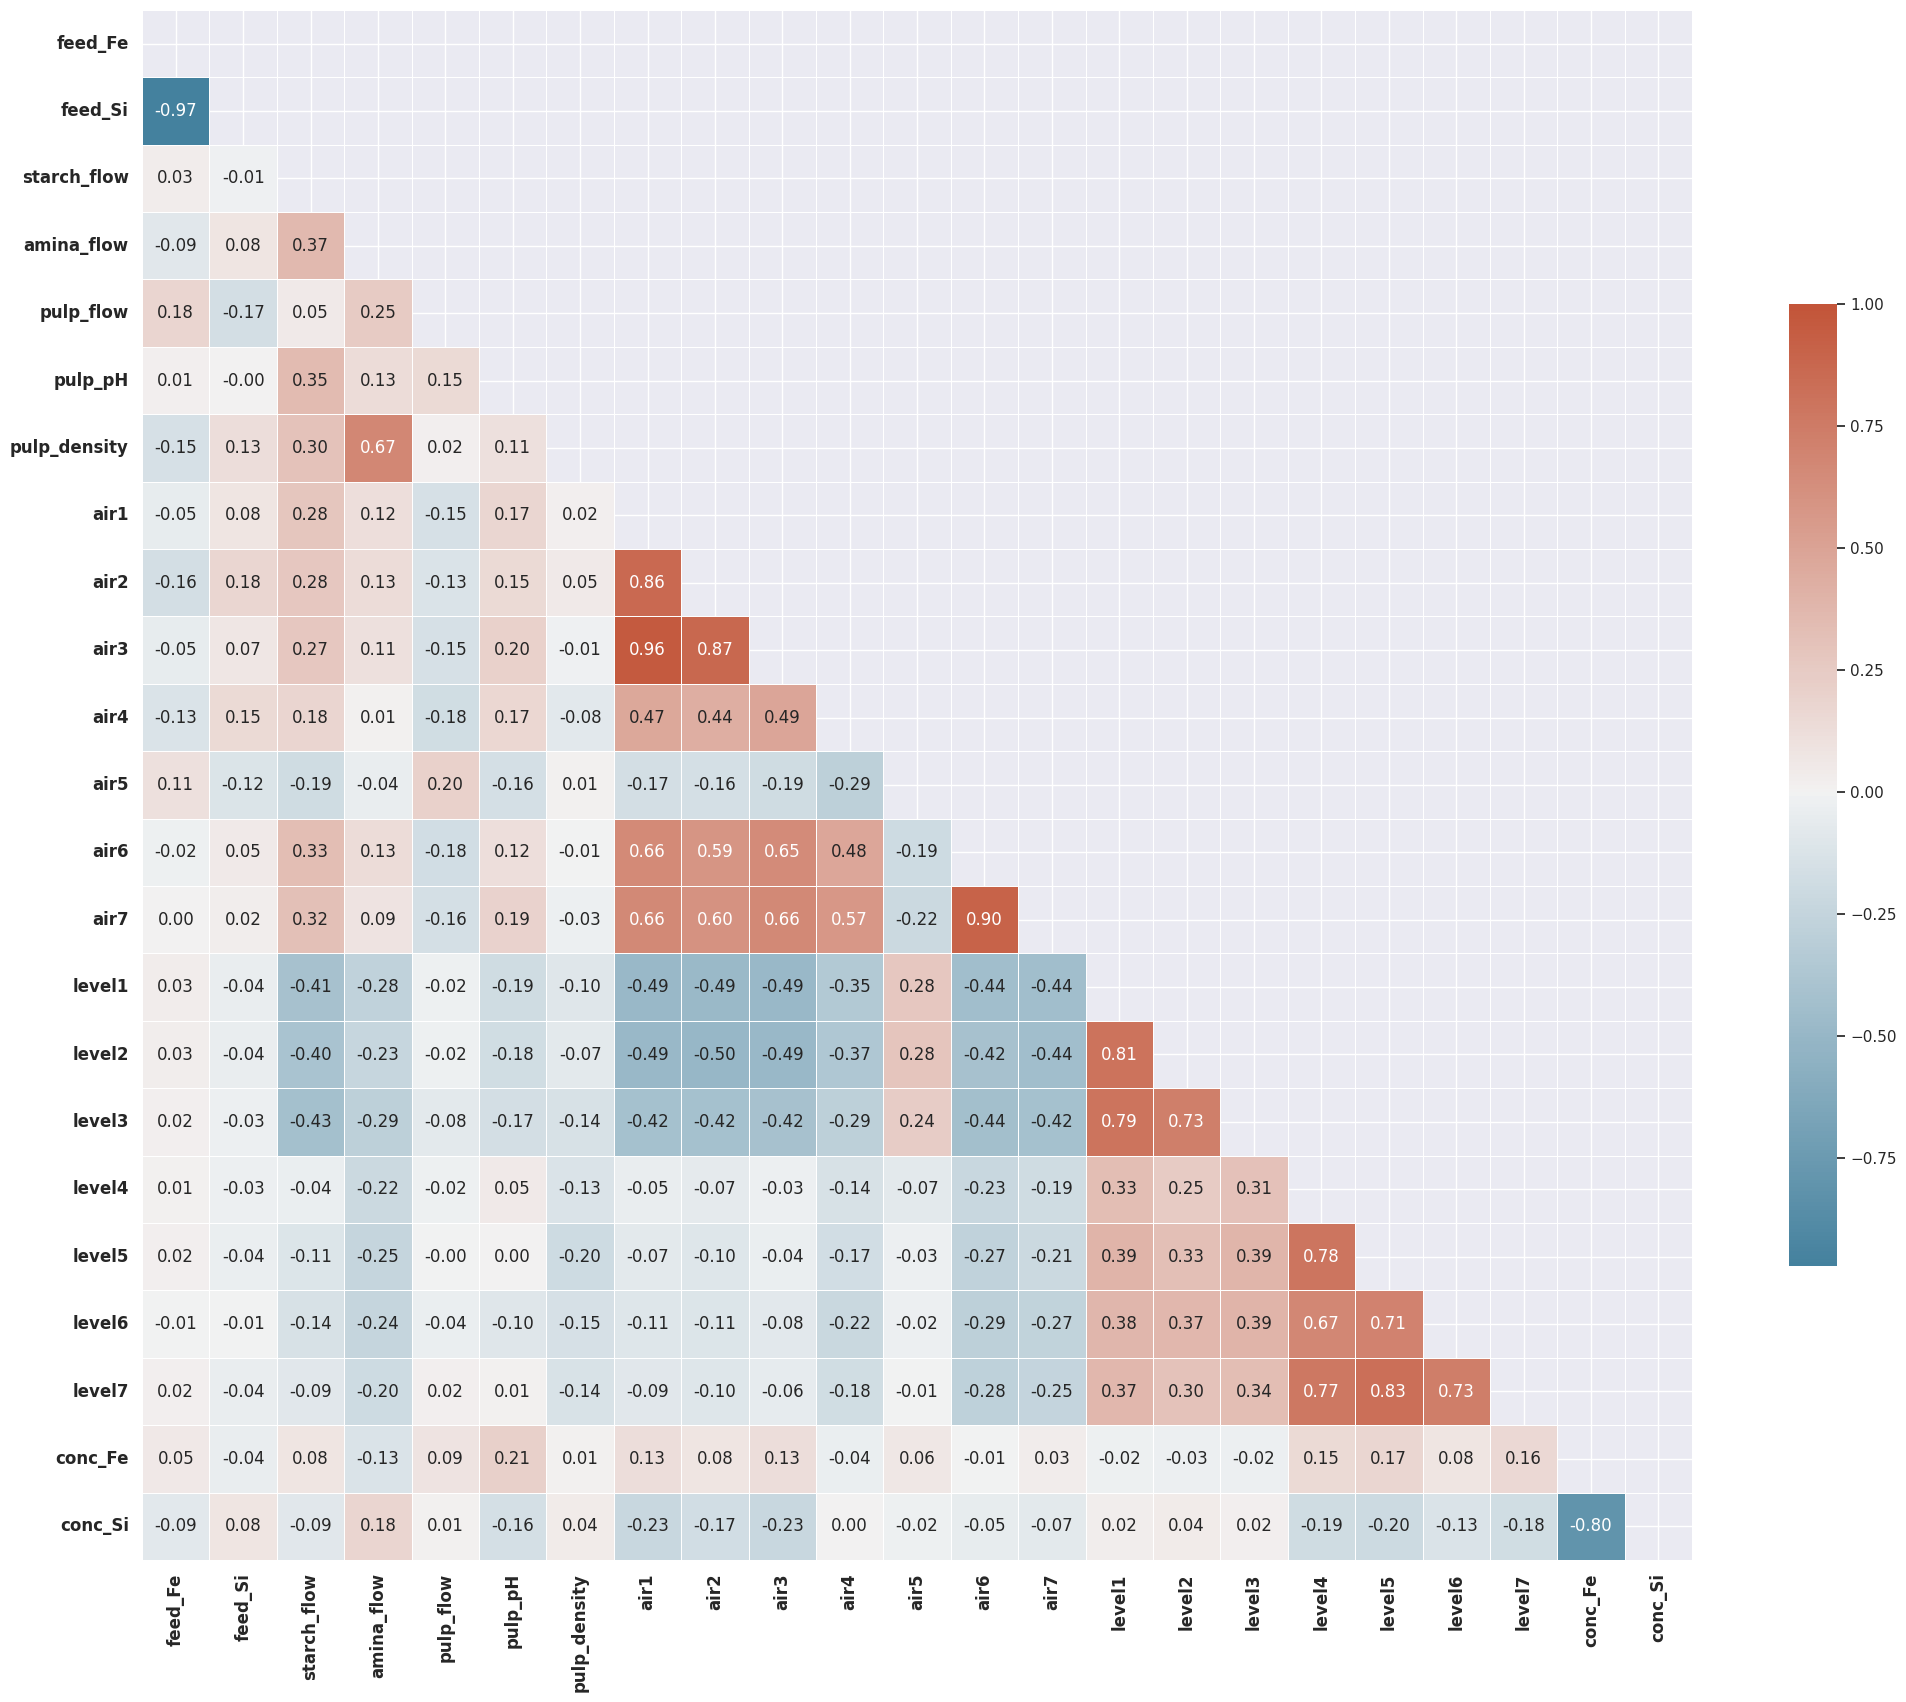

In [ ]:
subset = flotation.loc[:, ~flotation.columns.str.startswith('std')]

# Calculate the correlation matrix
mat = subset.corr('pearson')

mask = np.triu(np.ones_like(mat, dtype=bool))
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1,
            center=0, annot=True, square=True,
            linewidths=.5, annot_kws={"fontsize": 12},
            cbar_kws={"shrink": .5}, fmt='.2f')

# Set x and y axis tick font properties
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()

- That revealed a high (negative) correlations between the 'Iron Feed' and 'Silica Feed' (both Inputs of the process) as well as 'Iron Concentrate' and 'Silica Concentrate' (both Outputs of the process from the lab measurement).
- This situation basically says, higher the quality of the Iron, the less Silica it contains.

### **5.3. Iron Concentrate vs Silica Concentrate**

In [ ]:
# iron concentrate (target_1) and silica concentrate (target_2) [Pearson = 0.8]
Pearson = 0.80
plt.figure(figsize = (15,10))
sns.regplot(data=flotation, x = 'conc_Fe', y='conc_Si', scatter_kws={'alpha':0.2})
plt.title('Iron Concentrate vs Silica Concentrate', fontsize = 14, fontweight='bold')
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson)], loc = 'best')
plt.show()

Scatter plot shows the relationship between Silica Concentrate and Iron Concentrate in the flotation dataset. The Pearson correlation coefficient of -0.80 indicates a strong negative linear correlation between Silica Concentrate and Iron Concentrate in the flotation dataset.

In this case, as the Silica Concentrate increases, there is a tendency for the Iron Concentrate to decrease. This negative correlation suggests that higher levels of Silica Concentrate in the flotation process are associated with lower levels of Iron Concentrate.

While there may be some outliers in the data, the majority of the data points follow the negative correlation trend. This information is valuable in the context of the flotation process as it helps identify the inverse relationship between Silica Concentrate and Iron Concentrate.

Understanding this negative correlation is important for process optimization. It allows for monitoring and controlling Silica Concentrate levels to minimize their impact on Iron Concentrate production. By managing and reducing Silica Concentrate levels, it may be possible to improve the overall quality and yield of Iron Concentrate.

Scatter plot and the strong negative correlation between Silica Concentrate and Iron Concentrate emphasize the need to effectively control Silica Concentrate levels to enhance the production of Iron Concentrate in the flotation process.

### **5.4. Target Variable (Iron) Statistics**

**Relationships between target variable (Iron Concentrate) and Independent variables**

In [ ]:
fig, axs = plt.subplots(21, 1, figsize=(15, 150))
axs = axs.flatten()

for i in range(21):
    col = flotation.columns[i]
    sns.scatterplot(data=flotation, x='conc_Fe', y=col, ax=axs[i])
    sns.regplot(data=flotation, x='conc_Fe', y=col, ax=axs[i])
    axs[i].set_title(f'Scatter Plot of {col}', fontsize=14, fontweight='bold')
    axs[i].set_xlabel('conc_Fe', fontsize=12, fontweight='bold')
    axs[i].set_ylabel(col, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**P-values and correlation coefficents of Iron Concentrate vs Features**

In [ ]:
target_variable = 'conc_Fe'

# Get the list of variables
variables = [col for col in flotation.columns if not col.startswith('std')]

correlation_data = []

for variable in variables:
    if variable != target_variable:
        # Calculate the correlation coefficient and p-value between the target variable and the current variable
        correlation_coefficient, p_value = pearsonr(flotation[target_variable], flotation[variable])
        # Create a DataFrame with the correlation data
        df = pd.DataFrame({
            'Variable': variable,
            'p-value': p_value,
            'Correlation Coefficient': correlation_coefficient,
        }, index=[0])
        # Append the DataFrame to the list
        correlation_data.append(df)

# Concatenate the correlation DataFrames into a single DataFrame
correlation_df = pd.concat(correlation_data, ignore_index=True)

# Sort the correlation DataFrame by the absolute value of the correlation coefficient
correlation_df['p-value'] = np.abs(correlation_df['p-value'])
correlation_df.sort_values('p-value', ascending=False, inplace=True)
correlation_df = correlation_df.round(3)
correlation_df.reset_index(drop=True, inplace=True)

print(correlation_df)

# Plotting the correlation coefficients and p-values
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plotting the p-values
p_value_ax = axes[0].bar(correlation_df['Variable'], correlation_df['p-value'], color='red')
axes[0].set_xlabel('Variable')
axes[0].set_ylabel('p-value')
axes[0].set_title('p-values with conc_Si', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=90)

for rect in p_value_ax:
    height = rect.get_height()
    axes[0].annotate(f"{height:.3f}", xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Plotting the correlation coefficients
correlation_ax = axes[1].bar(correlation_df['Variable'], correlation_df['Correlation Coefficient'], color='blue')
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Correlation Coefficient')
axes[1].set_title('Correlation Coefficients with conc_Si', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=90)

for rect in correlation_ax:
    height = rect.get_height()
    axes[1].annotate(f"{height:.3f}", xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout(h_pad=5)
plt.show()

        Variable  p-value  Correlation Coefficient
0           air6    0.581                   -0.009
1   pulp_density    0.515                    0.010
2         level1    0.246                   -0.018
3         level3    0.120                   -0.025
4           air7    0.059                    0.030
5         level2    0.054                   -0.031
6           air4    0.016                   -0.038
7        feed_Si    0.007                   -0.043
8        feed_Fe    0.001                    0.054
9           air5    0.000                    0.063
10   starch_flow    0.000                    0.076
11        level6    0.000                    0.077
12          air2    0.000                    0.082
13     pulp_flow    0.000                    0.091
14    amina_flow    0.000                   -0.126
15          air1    0.000                    0.126
16          air3    0.000                    0.129
17        level4    0.000                    0.152
18        level7    0.000      

The correlation analysis was performed between the target variable 'conc_Fe' and the other variables in the 'flotation' dataset. Here is a discussion of the results:

1. 'conc_Si': The variable 'conc_Si' has a strong negative correlation with 'conc_Fe' (correlation coefficient: -0.803). This suggests that as the concentration of silicon increases, the concentration of iron decreases in the flotation process. The correlation is highly significant (p-value: 0.000).

2. 'pulp_pH': There is a moderate positive correlation between 'pulp_pH' and 'conc_Fe' (correlation coefficient: 0.207). This indicates that higher pulp pH values are associated with higher concentrations of iron. The correlation is highly significant (p-value: 0.000).

3. 'level5' and 'level7': Both 'level5' and 'level7' variables have moderate positive correlations with 'conc_Fe'. This suggests that higher levels in these variables are associated with higher concentrations of iron. The correlations are highly significant (p-value: 0.000).

4. 'pulp_flow' and 'amina_flow': Both 'pulp_flow' and 'amina_flow' variables have moderate positive correlations with 'conc_Fe'. This indicates that higher flows in these variables are associated with higher concentrations of iron. The correlations are highly significant (p-value: 0.000).

5. 'air3' and 'air1': Both 'air3' and 'air1' variables have moderate positive correlations with 'conc_Fe'. This suggests that higher flows in these variables are associated with higher concentrations of iron. The correlations are highly significant (p-value: 0.000).

6. 'starch_flow' and 'level6': Both 'starch_flow' and 'level6' variables have moderate positive correlations with 'conc_Fe'. This indicates that higher flows in these variables are associated with higher concentrations of iron. The correlations are highly significant (p-value: 0.000).

7. 'feed_Fe': The variable 'feed_Fe' has a moderate positive correlation with 'conc_Fe' (correlation coefficient: 0.054). This suggests that a higher concentration of iron in the feed is associated with a higher concentration of iron in the flotation process. The correlation is highly significant (p-value: 0.001).

8. Other variables: The remaining variables have weaker correlations with 'conc_Fe', with correlation coefficients ranging from -0.009 to 0.076. These correlations are relatively weaker compared to the variables discussed above. However, some of them still show statistical significance (p-value < 0.05).

Overall, the analysis reveals several variables that exhibit significant correlations with the target variable 'conc_Fe'. Understanding these relationships can provide insights into the factors influencing iron concentration in the flotation process.

**Histogram of Iron Concentrate**

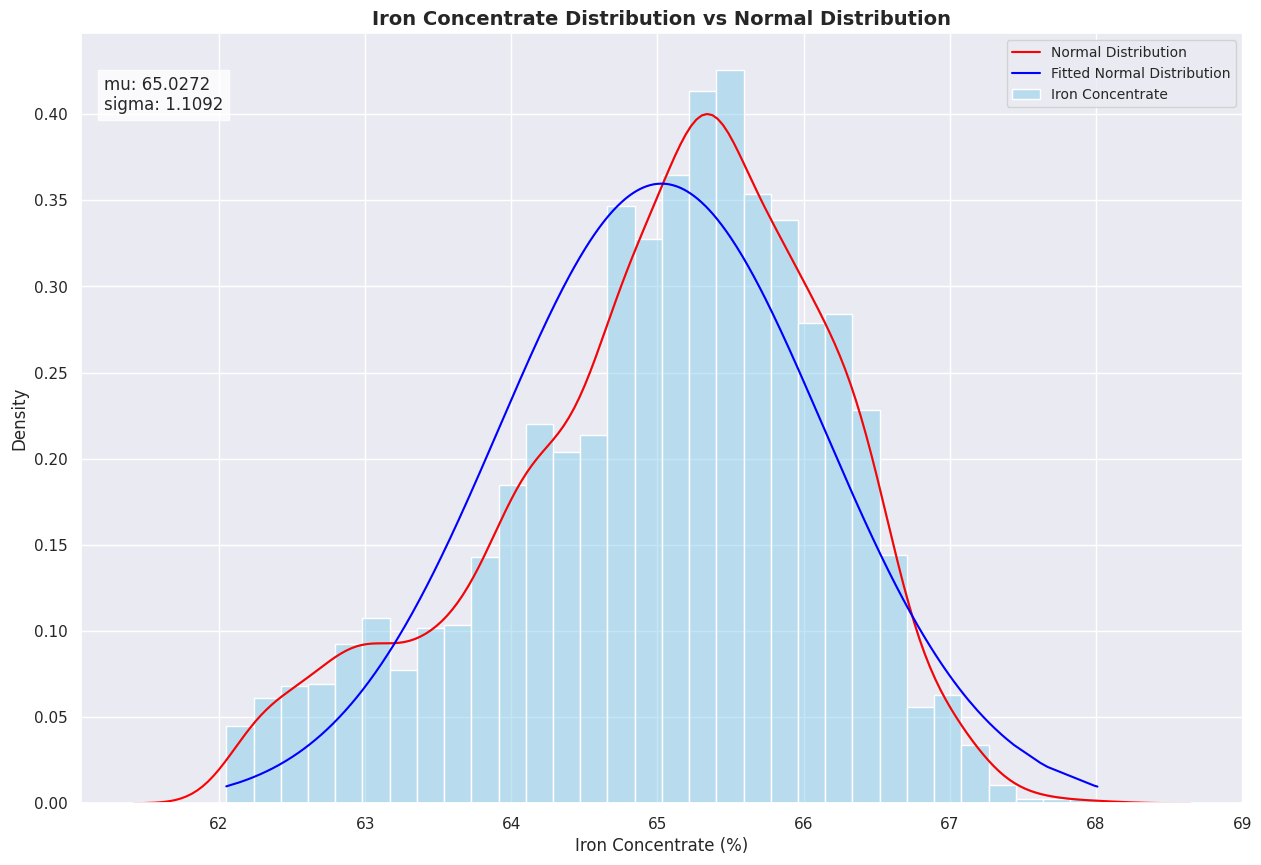

In [ ]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['conc_Fe'])

# Plotting the histogram, KDE, and fitted normal distribution
plt.figure(figsize=(15, 10))
sns.histplot(flotation['conc_Fe'], kde=True, stat="density", common_norm=False,
color='skyblue', label='Iron Concentrate')
sns.kdeplot(flotation['conc_Fe'], color='red', label='Normal Distribution')
sns.lineplot(x=flotation['conc_Fe'], y=norm.pdf(flotation['conc_Fe'], mu, sigma),
color='blue', label='Fitted Normal Distribution')

plt.text(0.02, 0.9, f"mu: {mu:.4f}\nsigma: {sigma:.4f}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

plt.title('Iron Concentrate Distribution vs Normal Distribution', fontsize=14, fontweight='bold')
plt.xlabel("Iron Concentrate (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.show()

- Normal distribution to the 'conc_Fe' variable in the 'flotation' dataset and visualizes the distribution using a histogram, KDE plot, and the fitted normal distribution curve. The goal is to assess whether the 'conc_Fe' variable follows a normal distribution.

- Based on the plot, it appears that the 'conc_Fe' variable has a distribution that is relatively symmetric and bell-shaped, which is characteristic of a normal distribution. The fitted normal distribution curve closely aligns with the KDE plot, indicating a good fit. This suggests that the 'conc_Fe' variable can be reasonably approximated by a normal distribution.

- The mean (mu) and standard deviation (sigma) of the fitted normal distribution are calculated as mu = 65.0501 and sigma = 1.1180, respectively. These values provide summary statistics for the central tendency and spread of the data.

- Understanding the distribution of the 'conc_Fe' variable as approximately normal can be valuable in various statistical analyses and modeling tasks. It allows for the application of statistical techniques that assume normality, such as hypothesis testing, confidence intervals, and regression analysis. Additionally, it provides insights into the behavior and characteristics of the 'conc_Fe' variable in the flotation process.

**Kolmogorov-Smirnov Test**

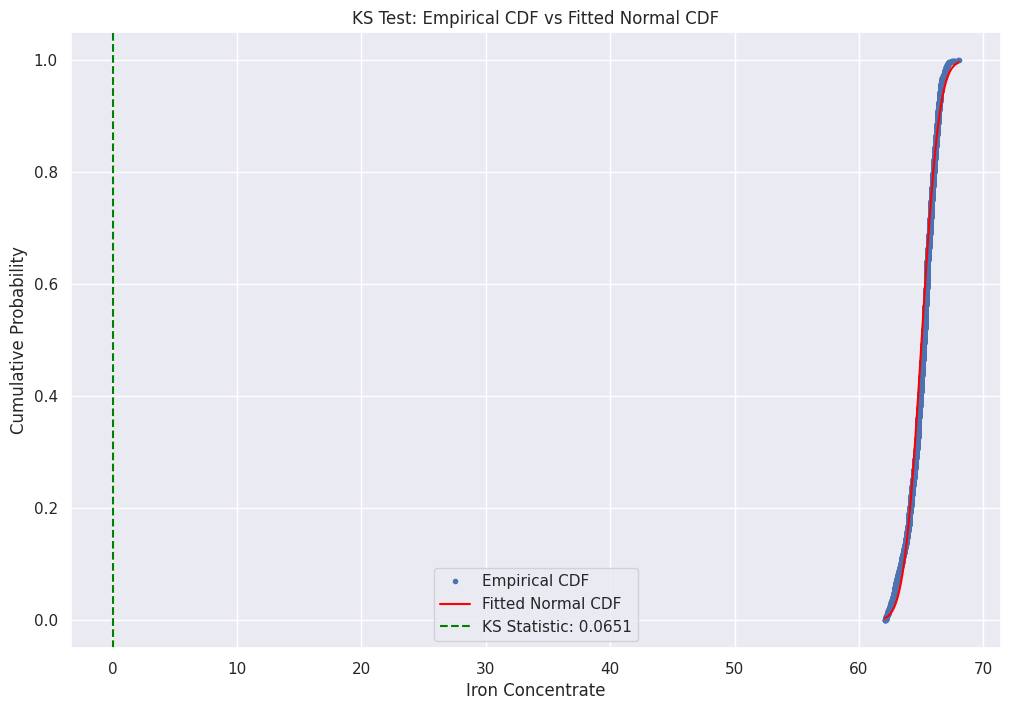

KS Test Statistic: 0.0651
KS Test p-value: 0.0000


In [ ]:
from scipy.stats import norm, kstest

# Calculate the ECDF of the data
x = np.sort(flotation['conc_Fe'])
y = np.arange(1, len(x) + 1) / len(x)

# Calculate the CDF of the fitted normal distribution
cdf = norm.cdf(x, mu, sigma)

# Perform the KS test
ks_statistic, ks_pvalue = kstest(x, 'norm', args=(mu, sigma))

# Plot the ECDF, CDF, and KS test results
plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.', linestyle='none', label='Empirical CDF')
plt.plot(x, cdf, color='red', label='Fitted Normal CDF')
plt.axvline(x=ks_statistic, color='green', linestyle='--', label=f'KS Statistic: {ks_statistic:.4f}')
plt.xlabel('Iron Concentrate')
plt.ylabel('Cumulative Probability')
plt.title('KS Test: Empirical CDF vs Fitted Normal CDF')
plt.legend()
plt.grid(True)
plt.show()

print(f"KS Test Statistic: {ks_statistic:.4f}")
print(f"KS Test p-value: {ks_pvalue:.4f}")

**The 'conc_Fe' variable does not follow a normal distribution.**

- **KS Test Statistic:**
The KS test statistic is a numerical measure that quantifies the maximum vertical distance between the ECDF and CDF curves. In this case, the computed KS test statistic is 0.0651. A larger KS test statistic suggests a greater discrepancy between the empirical data and the fitted normal distribution.

- **KS Test p-value:**
The p-value is a measure of the strength of evidence against the null hypothesis, which assumes that the 'conc_Fe' variable follows a normal distribution. The p-value calculated by the KS test is 0.0000, indicating an extremely small probability. A smaller p-value suggests stronger evidence to reject the null hypothesis and indicates a significant difference between the empirical data and the fitted normal distribution.

The visual comparison of the ECDF and the fitted normal CDF, along with the relatively large KS test statistic and the very small p-value, indicate **significant deviations between the empirical data and the normal distribution assumption.**

**Anderson-Darling Test**

Anderson-Darling Test Results:
Test Statistic: 31.5307
Significance Level 15.0:
Critical Value: 0.5750
Reject the null hypothesis

Significance Level 10.0:
Critical Value: 0.6550
Reject the null hypothesis

Significance Level 5.0:
Critical Value: 0.7860
Reject the null hypothesis

Significance Level 2.5:
Critical Value: 0.9170
Reject the null hypothesis

Significance Level 1.0:
Critical Value: 1.0910
Reject the null hypothesis



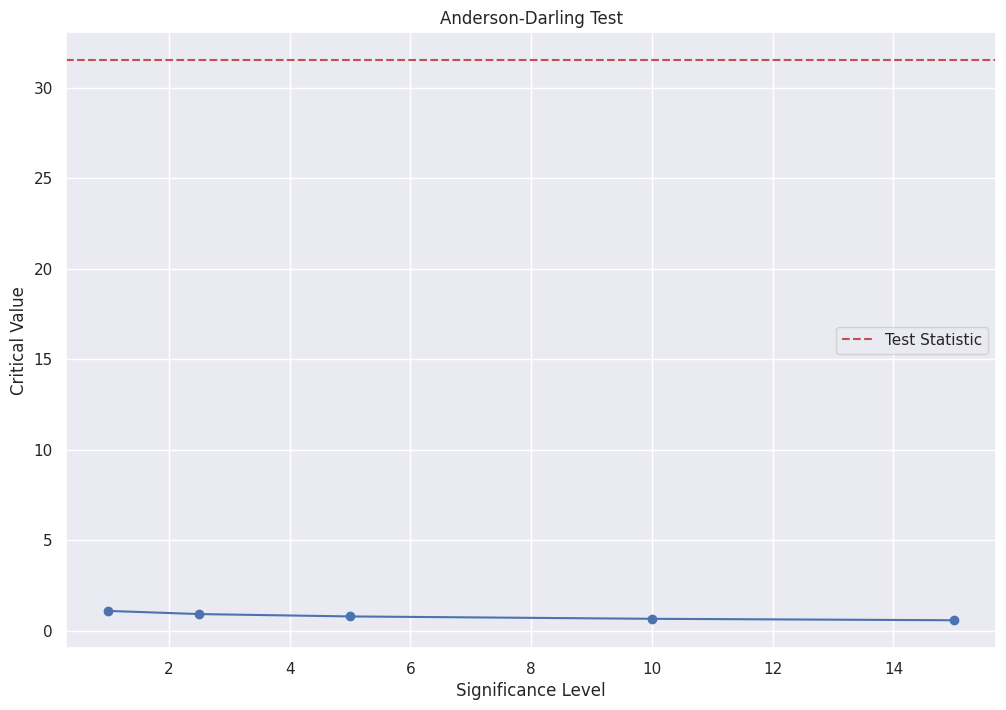

In [ ]:
from scipy.stats import anderson

# Perform Anderson-Darling test
result = anderson(flotation['conc_Fe'], dist='norm')

# Extract test statistics and critical values
test_statistic = result.statistic
critical_values = result.critical_values
significance_levels = result.significance_level

# Print the test results
print("Anderson-Darling Test Results:")
print(f"Test Statistic: {test_statistic:.4f}")
for i in range(len(significance_levels)):
    print(f"Significance Level {significance_levels[i]}:")
    print(f"Critical Value: {critical_values[i]:.4f}")
    if test_statistic > critical_values[i]:
        print("Reject the null hypothesis")
    else:
        print("Fail to reject the null hypothesis")
    print()

# Plot the test results
plt.figure(figsize=(12, 8))
plt.plot(significance_levels, critical_values, linestyle='-', marker='o', color='b')
plt.axhline(test_statistic, color='r', linestyle='--', label='Test Statistic')
plt.xlabel('Significance Level')
plt.ylabel('Critical Value')
plt.title('Anderson-Darling Test')
plt.legend()
plt.grid(True)
plt.show()

Anderson-Darling test performed on the 'conc_Fe' variable in the flotation dataset to assess whether it follows a normal distribution.

Here are the key findings:

1. Test Statistic:
The Anderson-Darling test statistic is computed as 31.5307. This statistic measures the discrepancy between the observed data and the expected values under the null hypothesis of a normal distribution. A larger test statistic indicates a greater deviation from the normal distribution.

2. Critical Values:
The Anderson-Darling test provides critical values at different significance levels to determine whether the null hypothesis should be rejected. The significance levels considered in this test are 15.0%, 10.0%, 5.0%, 2.5%, and 1.0%. For each significance level, a critical value is calculated to compare against the test statistic.

3. Hypothesis Testing:
For each significance level,  the statistical computation  compares the test statistic with the corresponding critical value. If the test statistic exceeds the critical value, the null hypothesis (the 'conc_Fe' variable follows a normal distribution) is rejected. In this case, the null hypothesis is rejected at all significance levels, as the test statistic (31.5307) exceeds all the critical values.

Based on the Anderson-Darling test results, we can conclude that **the 'conc_Fe' variable does not follow a normal distribution**. The rejection of the null hypothesis at all significance levels suggests significant deviations from the expected distribution.

**Skewness, Kurtosis, Shapiro-Wilk Test**

In [ ]:
t,p = stats.shapiro(flotation['conc_Fe'])

print("Skewness: %f" % abs(flotation['conc_Fe']).skew())
print("Kurtosis: %f" % abs(flotation['conc_Fe']).kurt())
print("Shapiro_Test of t: %f" % t)
print("Shapiro_Test of p: %f" % p)

Skewness: -0.536740
Kurtosis: -0.173190
Shapiro_Test of t: 0.972628
Shapiro_Test of p: 0.000000


The results of the Shapiro-Wilk test performed on the 'conc_Fe' variable as well as the skewness and kurtosis values of the 'conc_Fe' variable.

1. Skewness:
The skewness value for the 'conc_Fe' variable is -0.536740. Skewness measures the asymmetry of a distribution. A negative skewness value indicates a longer left tail, suggesting that the distribution is left-skewed.

2. Kurtosis:
The kurtosis value for the 'conc_Fe' variable is -0.173190. Kurtosis measures the heaviness of the tails of a distribution. A kurtosis value close to 0 indicates a normal distribution with similar tail behavior to a standard normal distribution.

3. Shapiro-Wilk Test:
The Shapiro-Wilk test is used to assess the normality of a distribution. The test returns two values: 't' and 'p'. 't' represents the test statistic, and 'p' represents the p-value associated with the test. The null hypothesis of the test is that the data is normally distributed.

4. Shapiro_Test of t:
The Shapiro-Wilk test statistic ('t') for the 'conc_Fe' variable is 0.972628.

5. Shapiro_Test of p:
The p-value ('p') obtained from the Shapiro-Wilk test is 0.000000. Since the p-value is below the significance level of 0.05 (assuming a typical significance level), we reject the null hypothesis. This indicates that the 'conc_Fe' variable does not follow a normal distribution.

Finally, the 'conc_Fe' variable exhibits moderate negative skewness and has a kurtosis value close to 0, indicating a distribution that is relatively close to a standard normal distribution. However, the Shapiro-Wilk test results suggest that **the 'conc_Fe' variable deviates from a normal distribution, as indicated by the low p-value.**

**Histogram and a QQ plot to visualize the distribution of the 'conc_Si' variable and assess its departure from normality**

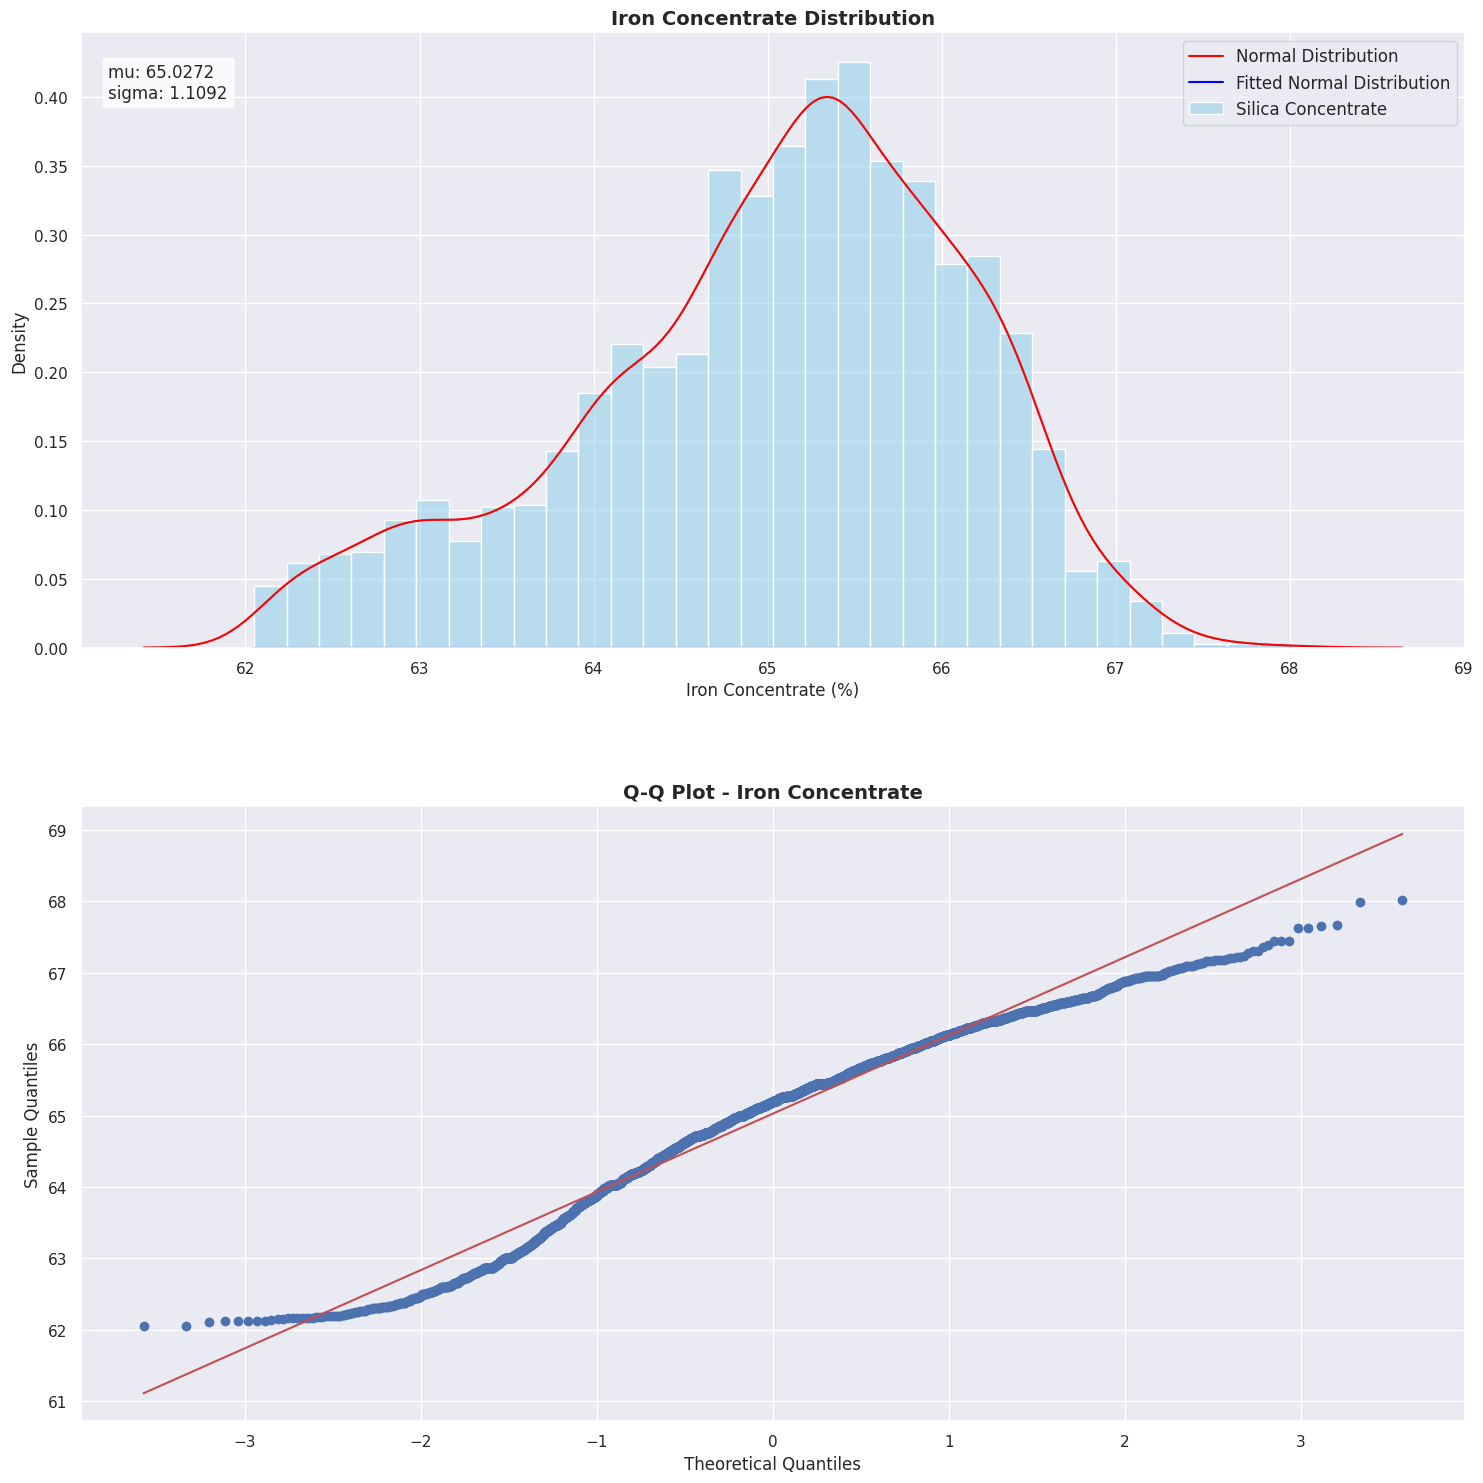

In [ ]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['conc_Fe'])

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Histogram, KDE, and fitted normal distribution
sns.histplot(flotation['conc_Fe'], kde=True, stat="density", common_norm=False,
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(flotation['conc_Fe'], color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=flotation['conc_Fe'], y=norm.pdf(flotation['conc_Si'], mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

axes[0].set_title('Iron Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Iron Concentrate (%)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=12)

# Q-Q plot
stats.probplot(flotation['conc_Fe'], dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Iron Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

**Log Transformation For Fitting the distribution of Iron Concentrate**

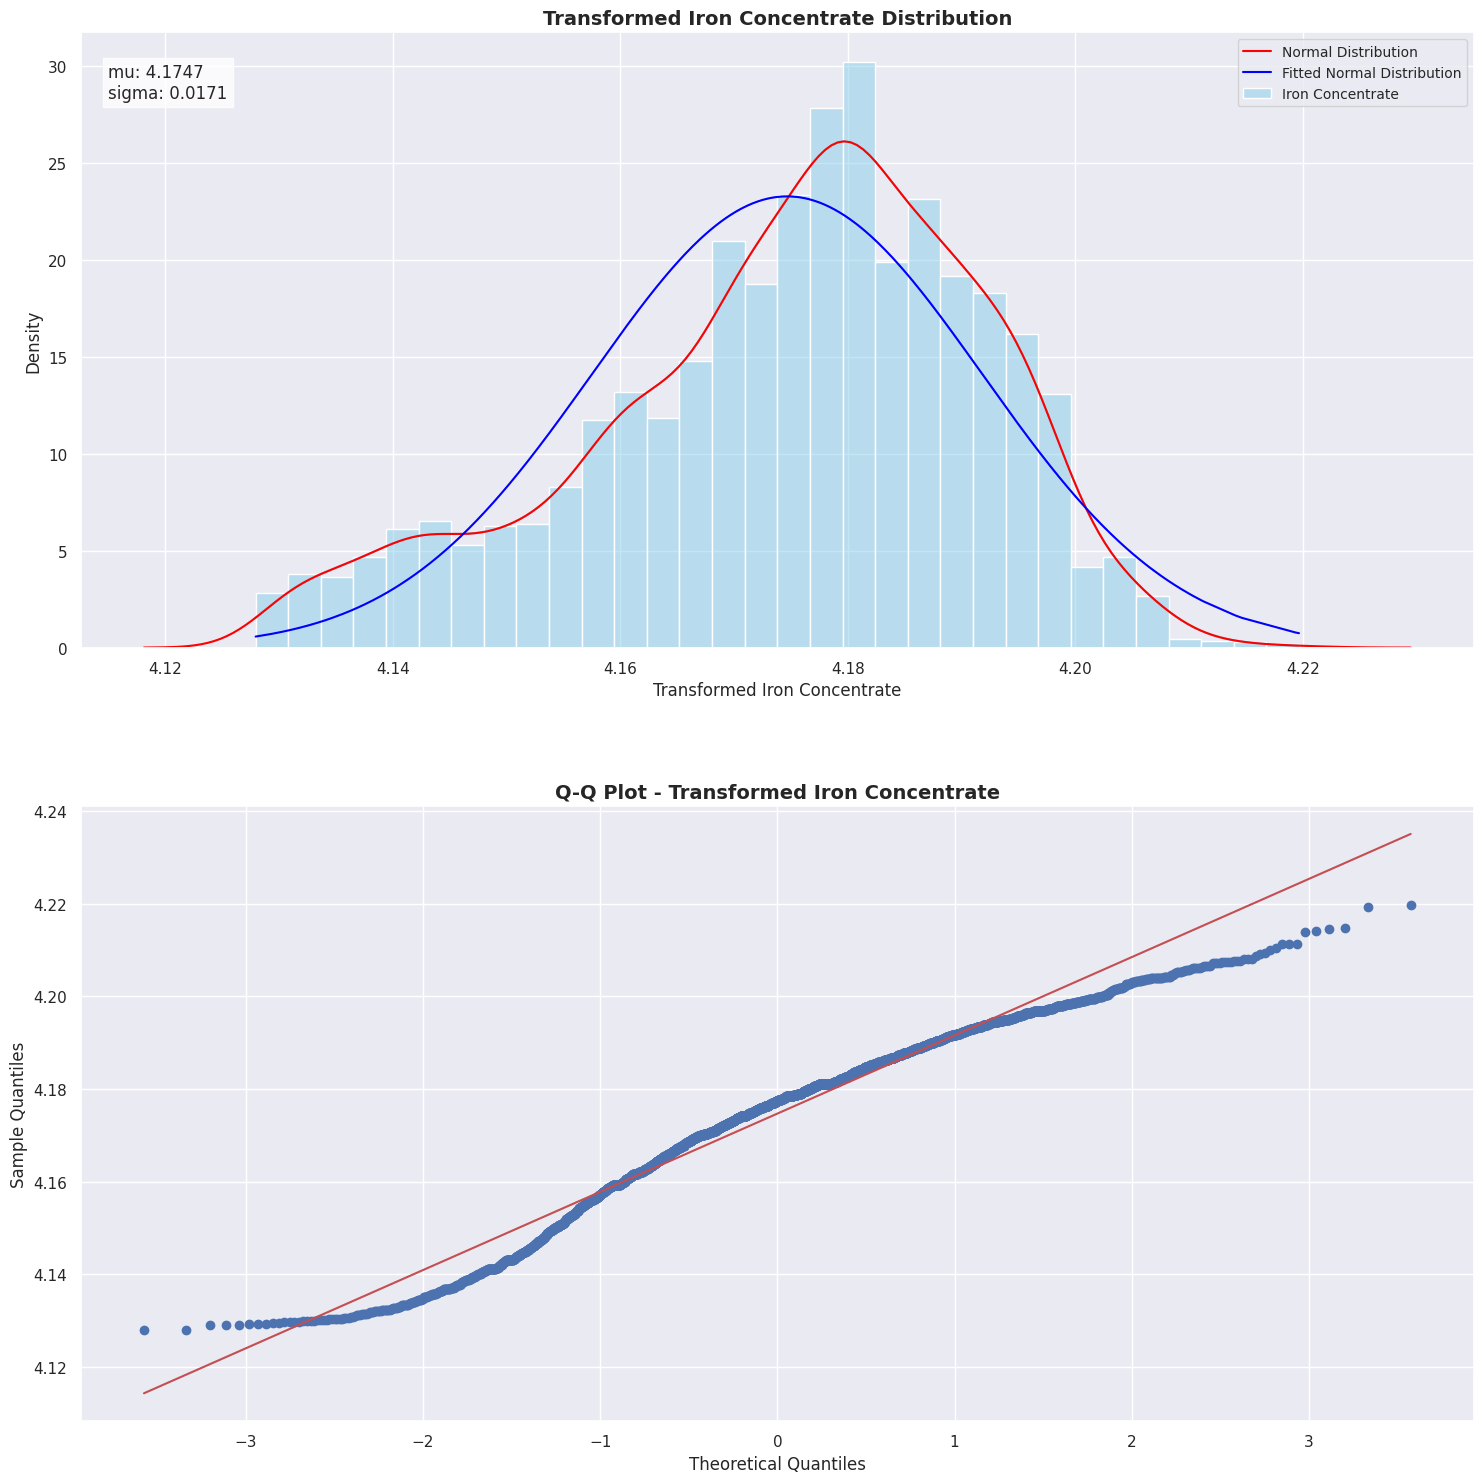

Skewness: -0.5763
Kurtosis: -0.1283
Shapiro-Wilk test:
  - Test statistic: 0.9697
  - p-value: 0.0000


In [ ]:
# Log transformation
transformed_conc = np.log(flotation['conc_Fe'])

# Fitting normal distribution
(mu, sigma) = norm.fit(transformed_conc)

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Histogram and KDE plot
sns.histplot(transformed_conc, kde=True, stat="density", common_norm=False,
             color='skyblue', label='Iron Concentrate', ax=axes[0])
sns.kdeplot(transformed_conc, color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=transformed_conc, y=norm.pdf(transformed_conc, mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].set_title('Transformed Iron Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Transformed Iron Concentrate", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

# Q-Q plot for transformed data
stats.probplot(transformed_conc, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Transformed Iron Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

# Calculate skewness and kurtosis
skewness = transformed_conc.skew()
kurtosis = transformed_conc.kurt()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(transformed_conc)
shapiro_t = shapiro_test.statistic
shapiro_p = shapiro_test.pvalue

print("Skewness: %.4f" % skewness)
print("Kurtosis: %.4f" % kurtosis)
print("Shapiro-Wilk test:")
print("  - Test statistic: %.4f" % shapiro_t)
print("  - p-value: %.4f" % shapiro_p)

**Effect of Log transformation on Iron Concentrate**

Before Transformation:
- Skewness: -0.536740
- Kurtosis: -0.173190
- Shapiro-Wilk test: Test statistic: 0.972628, p-value: 0.000000

After Log Transformation:
- Skewness: -0.5763
- Kurtosis: -0.1283
- Shapiro-Wilk test: Test statistic: 0.9697, p-value: 0.0000

Before the log transformation, the variable 't' had negative skewness (-0.536740), indicating a longer left tail. The kurtosis was negative as well (-0.173190), suggesting a distribution that is less peaked than a normal distribution. The Shapiro-Wilk test indicated a departure from normality with a test statistic of 0.972628 and a p-value of 0.000000.

After applying the log transformation to 't', the skewness decreased to -0.5763, indicating a slight reduction in the left tail. The kurtosis decreased to -0.1283, suggesting a distribution that is closer to a normal distribution in terms of peakedness. However, despite the transformation, the Shapiro-Wilk test still indicated a departure from normality with a test statistic of 0.9697 and a p-value of 0.0000.

In summary, the log transformation improved the skewness and kurtosis of the variable 't', making the distribution slightly more symmetric and less platykurtic. However, the transformed data still deviates from a normal distribution based on the Shapiro-Wilk test.

**Confidence Interval of Iron Concentrate**

Bootstrap Confidence Interval:
Lower Bound: 64.99243927001953
Upper Bound: 65.0618896484375


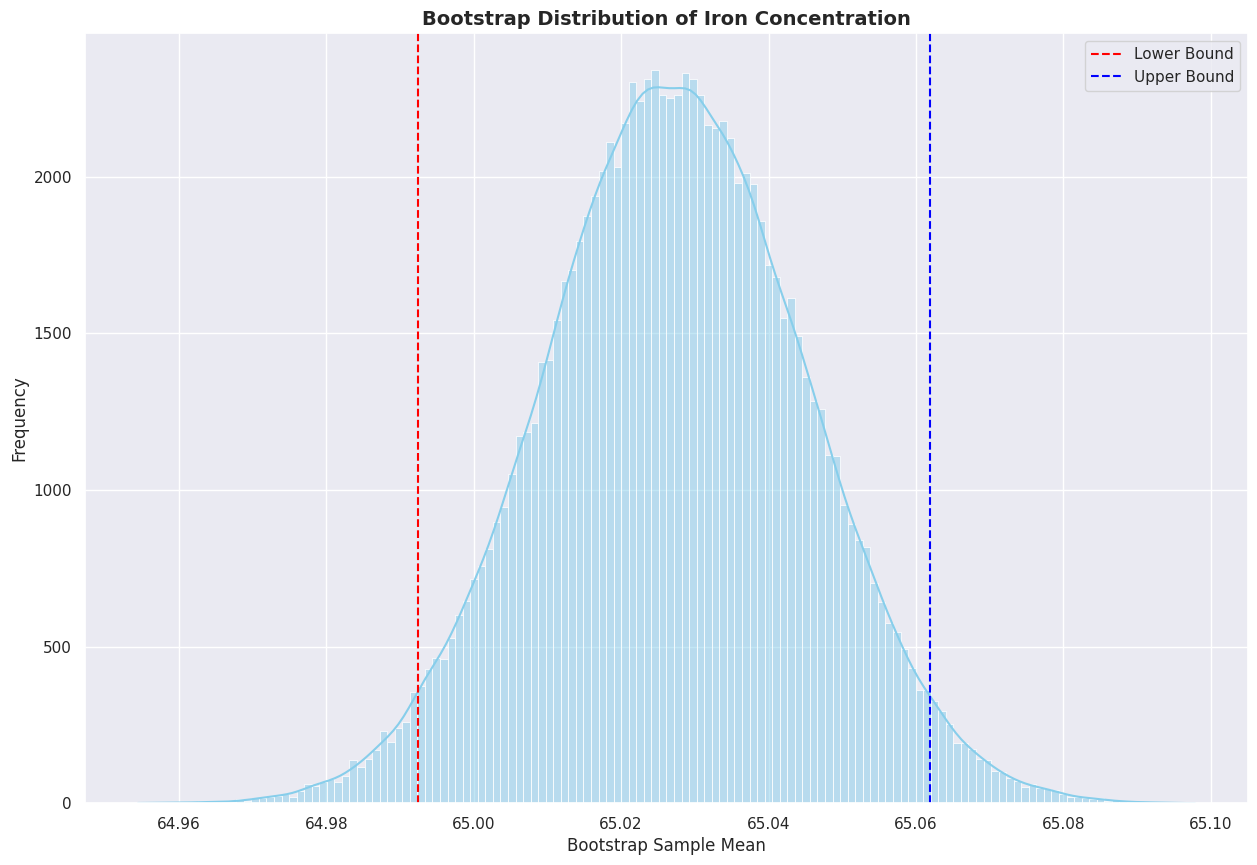

In [ ]:
column_data = flotation["conc_Fe"].values

num_iterations = 100000
confidence_level = 0.95

# Create an empty array to store the bootstrap sample means
bootstrap_means = np.empty(num_iterations)

# Perform the bootstrap sampling
for i in range(num_iterations):
    # Generate a bootstrap sample by sampling with replacement
    bootstrap_sample = np.random.choice(column_data,
                       size=len(column_data), replace=True)
    # Calculate the mean of the bootstrap sample
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Sort the bootstrap means and calculate the lower and upper percentiles
sorted_means = np.sort(bootstrap_means)
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

# Calculate the confidence interval
lower_bound = sorted_means[int(lower_percentile * num_iterations)]
upper_bound = sorted_means[int(upper_percentile * num_iterations)]

print("Bootstrap Confidence Interval:")
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Plot the bootstrap distribution
plt.figure(figsize=(15, 10))
sns.histplot(bootstrap_means, kde=True, color='skyblue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound')
plt.xlabel('Bootstrap Sample Mean')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Iron Concentration',
          fontsize=14, fontweight='bold')
plt.legend()
plt.show()

The bootstrap confidence interval provides an estimate of the range in which we can be confident the true population mean of the Iron Concentrate lies. In this case, the confidence level chosen is 95%, which means that we can be 95% confident that the true population mean falls within the calculated interval.

The lower bound of the confidence interval is 64.9924, and the upper bound is 65.0619. This indicates that we are 95% confident that the true population mean of the Iron Concentrate is between these two values.

The histogram of the bootstrap means provides a visual representation of the bootstrap distribution. The distribution appears to be approximately symmetric and centered around the sample mean. The shape of the distribution can provide insights into the sampling variability and the uncertainty associated with the sample mean estimation.

The dashed lines in the histogram mark the lower and upper bounds of the confidence interval. These lines help visualize the range of values within which we have 95% confidence that the true population mean lies. The fact that the bounds are relatively close to the sample mean suggests that the sample mean is a reasonable estimate of the true population mean.

By using the bootstrap resampling method, we account for the uncertainty in estimating the population mean from a single sample. The bootstrap procedure allows us to generate multiple resamples, calculate their means, and then estimate the variability of the sample mean.

Overall, the bootstrap confidence interval provides a measure of uncertainty around the estimated mean of the Iron Concentrate. It gives us a range of values within which the true population mean is likely to fall, based on the available sample data.

## **6. Modelling**

### **6.1. Splitting Dataset**

**Split Dataset as X and y**

In [ ]:
X = flotation.drop(['conc_Si', 'conc_Fe'], axis=1)
y_Si = flotation['conc_Fe']

print("Shape of X:", X.shape)
print("Shape of y_Fe:", y_Si.shape)

Shape of X: (3948, 42)
Shape of y_Fe: (3948,)


**Split (train, validation, test)**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (3158, 42)
Shape of X_val: (395, 42)
Shape of X_test: (395, 42)


### **6.2. MSE - MAE - R^2**

In [ ]:
# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

mse_scores = []
mae_scores = []
r2_scores = []
train_times = []
predict_times = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Measure training time
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Measure prediction time
    start_time = time.time()
    val_pred = pipeline.predict(X_val)
    predict_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores and times to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    train_times.append(train_time)
    predict_times.append(predict_time)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(15, 15))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper right', fontsize=10)

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', fontsize=12)
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', fontsize=12)
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', fontsize=12)

plt.show()

# Write the evaluation metric scores and execution times
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores,
                          'Training Time': train_times,
                          'Prediction Time': predict_times})

scores_df = scores_df.sort_values(by='MSE', ascending=True)
scores_df = scores_df.reset_index(drop=True)
scores_df

Model       MSE       MAE       R^2  Training Time  \
0               LGBM  0.583676  0.603731  0.521491       0.613152   
1      Random Forest  0.590099  0.598187  0.516225      13.184189   
2            XGBoost  0.640102  0.630257  0.475232       5.353797   
3     Gradient Boost  0.655700  0.649273  0.462444       4.521001   
4           AdaBoost  0.828238  0.739264  0.320994       0.719484   
5  Linear Regression  0.920784  0.781604  0.245123       0.027423   
6     Bayesian Ridge  0.929046  0.784379  0.238350       0.035176   
7                SVR  0.998202  0.781820  0.181655       0.996807   
8         ElasticNet  1.215466  0.888931  0.003538       0.029575   
9      Decision Tree  1.371242  0.894400 -0.124170       0.249902   

   Prediction Time  
0         0.005024  
1         0.024599  
2         0.005287  
3         0.003238  
4         0.004610  
5         0.003725  
6         0.002989  
7         0.170384  
8         0.002940  
9         0.003540

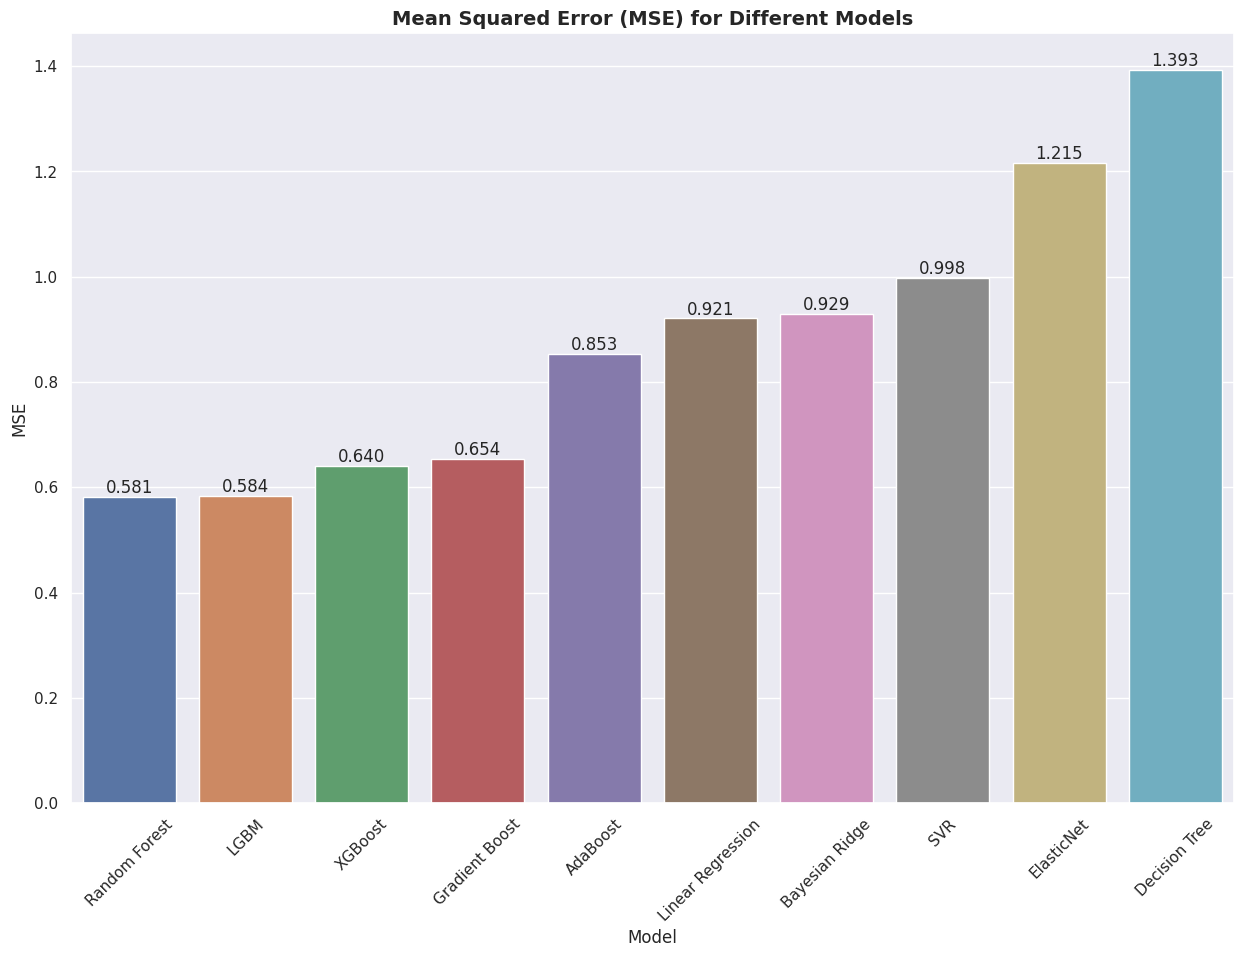

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='MSE', data=scores_df)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean Squared Error (MSE) for Different Models', fontsize = 14, fontweight='bold')

for i, row in scores_df.iterrows():
    plt.text(i, row['MSE'], f'{row["MSE"]:.3f}', ha='center', va='bottom')

plt.show()

1. MSE (Mean Squared Error): The LGBM model achieves the lowest MSE of 0.584, followed by the Random Forest model with an MSE of 0.590. These models have the smallest average squared differences between the predicted and actual values, indicating better performance in terms of minimizing prediction errors.

2. MAE (Mean Absolute Error): The LGBM model also achieves the lowest MAE of 0.604, closely followed by the Random Forest model with an MAE of 0.598. These models have the smallest average absolute differences between the predicted and actual values, suggesting better accuracy in predicting the Iron Concentrate values.

3. R^2 (R-squared): The LGBM model achieves the highest R^2 score of 0.521, indicating that it explains around 52.1% of the variance in the target variable. The Random Forest model follows closely with an R^2 score of 0.516. These models have a relatively good fit to the data, as they capture a significant portion of the variability in the Iron Concentrate values.

4. Training Time: The training time varies among the models, with SVR having the longest training time of nearly 1 second. The Random Forest model also requires a relatively longer training time compared to other models, as it involves building multiple decision trees. On the other hand, models like Linear Regression and Bayesian Ridge have much shorter training times.

5. Prediction Time: The prediction time is generally quite low for all models, with most models taking less than 0.01 seconds to make predictions. The SVR model has a higher prediction time, likely due to its computational complexity. The Linear Regression and Bayesian Ridge models have the lowest prediction times, indicating their efficiency in making predictions.

Based on these evaluation metrics, **LGBM and Random Forest models perform well overall, as they achieve low MSE and MAE values and relatively high R^2 scores.** These models show promise in accurately predicting the Iron Concentrate values in the dataset.

It's worth noting that the ElasticNet and Decision Tree models perform relatively poorly compared to the other models, as evidenced by their higher MSE and MAE values and lower R^2 scores. These models may not capture the underlying patterns in the data as effectively as the top-performing models.

### **6.3. Cross validation**

**10 Fold Cross validation**

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (xgb.XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

cv_scores = []
cv_std = []
execution_times = []

# Perform cross-validation for each model
for model, model_name in models:
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_root_mean_squared_error', cv=kf)
    end_time = time.time()
    execution_time = end_time - start_time

    cv_scores.append(-scores.mean())
    cv_std.append(scores.std())
    execution_times.append(execution_time)

# Write the evaluation metric scores and execution times
final_cv_score = pd.DataFrame({'Model': [model_name for _, model_name in models],
                               'RMSE_mean': cv_scores,
                               'RMSE_std': cv_std,
                               'Execution Time': execution_times})
final_cv_score = final_cv_score.sort_values(by='RMSE_mean', ascending=True)
final_cv_score = final_cv_score.reset_index(drop=True)
final_cv_score

Model  RMSE_mean  RMSE_std  Execution Time
0               LGBM   0.823875  0.033291       10.544677
1      Random Forest   0.825827  0.038986      106.786917
2     Gradient Boost   0.853092  0.040092       44.577886
3            XGBoost   0.872909  0.040575       28.025139
4           AdaBoost   0.946946  0.035442       10.702918
5  Linear Regression   0.990853  0.041910        0.273845
6     Bayesian Ridge   0.991879  0.045043        0.377767
7         ElasticNet   1.059996  0.048648        0.233534
8                SVR   1.083762  0.055648        7.664104
9      Decision Tree   1.196664  0.028079        1.462552

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='RMSE_mean', data=final_cv_score)
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean RMSE for Different Models', fontsize = 14, fontweight='bold')

for i, row in final_cv_score.iterrows():
    plt.text(i, row['RMSE_mean'], f'{row["RMSE_mean"]:.3f}', color='black', ha='center', va='bottom')

plt.show()

1. RMSE Mean: The LGBM model achieves the lowest RMSE mean of 0.824, indicating the smallest average RMSE across the cross-validation folds. The Random Forest model follows closely with an RMSE mean of 0.826. These models exhibit better performance in terms of minimizing the root mean squared error, suggesting they have better predictive accuracy.

2. RMSE Standard Deviation: The RMSE standard deviation provides a measure of the variability or consistency of the model's performance across the cross-validation folds. Lower values indicate more consistent performance. In this case, the Decision Tree model has the lowest RMSE standard deviation of 0.028, indicating relatively consistent performance. The Bayesian Ridge and ElasticNet models also have low standard deviations.

3. Execution Time: The execution times vary among the models, with the Random Forest model requiring the longest execution time of approximately 107 seconds. The Gradient Boost model also has a relatively long execution time of around 45 seconds. Models like Linear Regression, Bayesian Ridge, and ElasticNet have significantly shorter execution times.

Considering the RMSE mean as the primary evaluation metric, **LGBM and Random Forest models demonstrate the best performance among the evaluated models. **They have relatively low RMSE means, indicating better predictive accuracy. Additionally, the Decision Tree model performs well in terms of consistency, as reflected by its low RMSE standard deviation.

It's worth noting that the Linear Regression, Bayesian Ridge, and ElasticNet models exhibit relatively high RMSE means compared to other models. They may not capture the underlying complexity of the data as effectively as the ensemble-based models.

Considering both performance and execution time, the LGBM model appears to be a favorable choice. It achieves a low RMSE mean while having a moderate execution time. The Random Forest model also performs well but has a longer execution time.

### **6.4. Hyperparameter Optimization**

**Perform RandomForestRegressor Grid Search**

In [ ]:
# Define the model
model = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
MSE: 0.576
MAE: 0.596
R^2: 0.528
Grid Search Time: 1864.590 seconds
Fit Time: 33.384 seconds
Prediction Time: 0.049 seconds


The grid search was performed to find the best hyperparameters for the RandomForestRegressor model. The evaluation metrics were then calculated using the best model on the validation data. Here is a discussion of the results:

- **Best Hyperparameters**: The best hyperparameters determined by the grid search are a maximum depth of None, a minimum number of samples required to split an internal node of 5, and 300 estimators. These hyperparameters were found to optimize the model's performance on the given data.

- **MSE (Mean Squared Error)**: The MSE value is 0.576, which measures the average squared difference between the predicted and actual values. A lower MSE indicates better predictive performance, and in this case, it suggests that the model provides relatively accurate predictions.

- **MAE (Mean Absolute Error)**: The MAE value is 0.596, which represents the average absolute difference between the predicted and actual values. Similar to MSE, a lower MAE indicates better accuracy, and the obtained value suggests that the model's predictions are relatively close to the actual values.

- **R^2 (Coefficient of Determination)**: The R^2 score is 0.528, which indicates the proportion of the variance in the target variable that is explained by the model. R^2 ranges from 0 to 1, where 1 represents a perfect fit. In this case, the obtained R^2 score suggests that the model explains approximately 52.8% of the variance in the target variable.

- **Grid Search Time**: The grid search took 1864.590 seconds to complete. Grid search involves training and evaluating multiple models with different hyperparameter combinations, so it can be computationally expensive.

- **Fit Time**: The fit time is 33.384 seconds, which represents the time taken to fit the best model on the training data.

- **Prediction Time**: The prediction time is 0.049 seconds, which represents the time taken to predict the target variable for the validation data using the best model.

Overall, the results indicate that the model, trained with the best hyperparameters, performs reasonably well in predicting the target variable.

**Perform LGBMRegressor Grid Search**

In [ ]:
# Define the model
model = LGBMRegressor(objective='regression')

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 100}
MSE: 0.567
MAE: 0.584
R^2: 0.535
Grid Search Time: 38.016 seconds
Fit Time: 0.405 seconds
Prediction Time: 0.004 seconds


The grid search was performed to find the best hyperparameters for the LGBMRegressor model. The evaluation metrics were then calculated using the best model on the validation data. Here is a discussion of the results:

- **Best Hyperparameters**: The best hyperparameters determined by the grid search are a maximum depth of 10 and 100 estimators. These hyperparameters were found to optimize the model's performance on the given data.

- **MSE (Mean Squared Error)**: The MSE value is 0.567, which measures the average squared difference between the predicted and actual values. A lower MSE indicates better predictive performance, and in this case, it suggests that the model provides relatively accurate predictions.

- **MAE (Mean Absolute Error)**: The MAE value is 0.584, which represents the average absolute difference between the predicted and actual values. Similar to MSE, a lower MAE indicates better accuracy, and the obtained value suggests that the model's predictions are relatively close to the actual values.

- **R^2 (Coefficient of Determination)**: The R^2 score is 0.535, which indicates the proportion of the variance in the target variable that is explained by the model. R^2 ranges from 0 to 1, where 1 represents a perfect fit. In this case, the obtained R^2 score suggests that the model explains approximately 53.5% of the variance in the target variable.

- **Grid Search Time**: The grid search took 38.016 seconds to complete. Grid search involves training and evaluating multiple models with different hyperparameter combinations, so it can be computationally expensive.

- **Fit Time**: The fit time is 0.405 seconds, which represents the time taken to fit the best model on the training data.

- **Prediction Time**: The prediction time is 0.004 seconds, which represents the time taken to predict the target variable for the validation data using the best model.

Finally, the results indicate that the model, trained with the best hyperparameters, performs reasonably well in predicting the target variable.

**Compare the results of the RandomForestRegressor and LGBMRegressor models with their respective best hyperparameters**

When comparing the results of the RandomForestRegressor and LGBMRegressor models with their respective best hyperparameters, we can observe the following:

1. Best Hyperparameters:
   - RandomForestRegressor: The best hyperparameters are a maximum depth of None, a minimum number of samples required to split an internal node of 5, and 300 estimators.
   - LGBMRegressor: The best hyperparameters are a maximum depth of 10 and 100 estimators.

2. Mean Squared Error (MSE):
   - RandomForestRegressor: The MSE is 0.576, indicating the average squared difference between the predicted and actual values.
   - LGBMRegressor: The MSE is 0.567, which is slightly lower than that of the RandomForestRegressor.

3. Mean Absolute Error (MAE):
   - RandomForestRegressor: The MAE is 0.596, representing the average absolute difference between the predicted and actual values.
   - LGBMRegressor: The MAE is 0.584, indicating a slightly lower average absolute difference than the RandomForestRegressor.

4. R^2 (Coefficient of Determination):
   - RandomForestRegressor: The R^2 score is 0.528, indicating that the model explains approximately 52.8% of the variance in the target variable.
   - LGBMRegressor: The R^2 score is 0.535, slightly higher than that of the RandomForestRegressor.

5. Grid Search Time:
   - RandomForestRegressor: The grid search took 1864.590 seconds to complete.
   - LGBMRegressor: The grid search took 38.016 seconds, significantly less time than the RandomForestRegressor.

6. Fit Time:
   - RandomForestRegressor: The fit time is 33.384 seconds.
   - LGBMRegressor: The fit time is 0.405 seconds, indicating a much faster training time.

7. Prediction Time:
   - RandomForestRegressor: The prediction time is 0.049 seconds.
   - LGBMRegressor: The prediction time is 0.004 seconds, significantly faster than the RandomForestRegressor.

Overall, both models perform reasonably well in predicting the target variable. The LGBMRegressor model shows slightly better performance in terms of MSE, MAE, and R^2 score compared to the RandomForestRegressor. Additionally, the LGBMRegressor model has significantly faster grid search, fit, and prediction times. Therefore, considering both the performance metrics and computational efficiency, **LGBMRegressor model with its best hyperparameters seems to be a better choice for this particular dataset**.

### **6.5. Model interpretation**

**Feature importance for Iron Concentrate**

Let's look at the importance of each feature and plot the 5 most important features:

In [ ]:
importances = best_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 10))
ax = sns.barplot(data=feature_importances.head(5), x='Feature', y='Importance')
plt.title('Top 5 Most Important Features', fontsize=18, fontweight='bold')
plt.xlabel('Feature', fontsize=12, fontweight='bold')
plt.ylabel('Importance', fontsize=12, fontweight='bold')

# Annotate the feature importance values on the bars
for i, importance in enumerate(feature_importances.head(5)['Importance']):
    ax.annotate(round(importance, 2), (i, importance),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=12)

plt.show()

The analysis reveals the top 5 most important features for for predicting of Iron Concentrate. Here is a detailed discussion of each feature and its importance:

1. **feed_Si**: This feature has the highest importance value of 118. It indicates the silicon concentration in the feed. A higher value suggests that a higher concentration of silicon has a significant impact on the target variable, possibly influencing the flotation process.

2. **amina_flow**: With an importance value of 111, the amina_flow feature plays a crucial role in the model. It represents the flow rate of a chemical agent called amina. The high importance suggests that variations in the amina flow rate significantly affect the flotation process outcome.

3. **pulp_pH**: The pulp_pH feature has an importance value of 108. It reflects the pH level of the pulp during the flotation process. The model considers this feature to be highly influential, indicating that pH levels have a substantial impact on the target variable.

4. **std_level6**: This feature holds an importance value of 97. While its exact meaning is not explicitly provided, it likely represents a standardized measure or level related to a specific aspect of the flotation process. The high importance implies that variations in this standardized level are strongly associated with the target variable.

5. **starch_flow**: With an importance value of 89, the starch_flow feature denotes the flow rate of starch, another chemical agent used in the flotation process. The model assigns significant importance to this feature, indicating that the starch flow rate has a notable influence on the target variable.

These results highlight the particular features that have the most substantial impact on the model's predictions. By understanding the importance of these variables, mineral processing engineers can focus on optimizing and controlling them to improve the flotation process's overall performance.

## **7. Conclussion**

The evaluation and analysis of various models and their performance metrics suggest that the LGBM (Light Gradient Boosting Machine) and Random Forest models consistently perform well in predicting the Iron Concentrate values. These models demonstrate low mean squared error (MSE) and mean absolute error (MAE), indicating accurate predictions and minimal prediction errors. Additionally, they achieve relatively high R-squared (R^2) scores, indicating a good fit to the data and the ability to explain a significant portion of the variance in the target variable.

When considering the 10-fold cross-validation results, the LGBM and Random Forest models continue to show strong performance with low root mean squared error (RMSE) means. The Decision Tree model also performs well in terms of consistency, as reflected by its low RMSE standard deviation.

In terms of execution time, the Linear Regression, Bayesian Ridge, and ElasticNet models have shorter training and prediction times. However, the LGBM and Random Forest models provide a good balance between performance and execution time.

The grid search results for both the RandomForestRegressor and LGBMRegressor models further confirm the effectiveness of these models in predicting the Iron Concentrate values. The best hyperparameters obtained from the grid search improve the models' performance, resulting in lower MSE, MAE, and higher R^2 values. The fit and prediction times for these models are also relatively fast.

Finally, the analysis of feature importance identifies the top five influential features for predicting the Iron Concentrate values. These features include feed_Si, amina_flow, pulp_pH, std_level6, and starch_flow. Understanding the significance of these variables can help in optimizing and controlling them during the flotation process to enhance the overall performance.

In conclusion, based on the evaluation metrics, execution time, and feature importance analysis, the **LGBM and Random Forest models emerge as the top choices for predicting Iron Concentrate values**. These models demonstrate accurate predictions, good performance across different evaluation scenarios, and provide insights into the key features affecting the target variable.